# init

In [10]:
# library
library(feather)
library(repr)
library(jsonlite)

# data_dir
if (tolower(str_sub(getwd(), -11)) == 'onedrive/cc') {
    DATA_DIR = str_c(getwd(), '/data')
    WRDS_DOWNLOAD_DIR = str_c(DATA_DIR, '/WRDS-download')
    cat(str_c('Current working directory: ', getwd()))
} else {
    cat(str_c('Please set working dir to "~/onedrive/cc"'))
}

# options for plot
options(repr.plot.width=7, repr.plot.height=4, repr.plot.res = 300)

Current working directory: C:/Users/rossz/Onedrive/CC

# WRDS

## establish connection

In [23]:
library(RPostgres)

# connect to wrds
wrds <- dbConnect(Postgres(),
                  host='wrds-pgdata.wharton.upenn.edu',
                  port=9737,
                  dbname='wrds',
                  sslmode='require',
                  user='xiaomowu')

## unit test

In [ ]:
# Determine the data libraries available at WRDS
res <- dbSendQuery(wrds, "select distinct table_schema
                   from information_schema.tables
                   where table_type ='VIEW'
                   or table_type ='FOREIGN TABLE'
                   order by table_schema")
data <- dbFetch(res, n=-1)
dbClearResult(res)
print(setDT(data)[, sort(table_schema)])

In [ ]:
# Determine the datasets within a given library
library = 'wrdsapps'
res <- dbSendQuery(wrds, sprintf("select distinct table_name
                   from information_schema.columns
                   where table_schema='%s'
                   order by table_name", library))
data <- dbFetch(res, n=-1)
dbClearResult(res)
setDT(data)[, sort(table_name)] %>% print()

In [ ]:
# Determine the variables (column headers) within a given dataset
library = 'ibes'
dataset = 'det_epsus'
res <- dbSendQuery(wrds, sprintf("select column_name
                   from information_schema.columns
                   where table_schema='%s'
                   and table_name='%s'
                   order by column_name", library, dataset))
data <- dbFetch(res, n=-1)
dbClearResult(res)
setDT(data)[, column_name] %>% print()

In [ ]:
# To query the crsp.dsf dataset
library = "ibes"
dataset = 'ptgdet'
res <- dbSendQuery(wrds, sprintf("select * from %s.%s", library, dataset))
data <- dbFetch(res, n=-1) %>% setDT()
dbClearResult(res)
nrow(data)

## CIQ-Transcripts

> Transcript meta data

In [ ]:
library = "ciq"
dataset = 'wrds_transcript_detail'
res <- dbSendQuery(wrds, sprintf("select * from %s.%s", library, dataset))
ciq_transcript_detail <- dbFetch(res, n=-1) %>% setDT()
dbClearResult(res)
sv(ciq_transcript_detail, path=WRDS_DOWNLOAD_DIR)
ciq_transcript_detail[1]

In [ ]:
nrow(ciq_transcript_detail)

> Transcript speaker

In [ ]:
library = "ciq"
dataset = 'wrds_transcript_person'
res <- dbSendQuery(wrds, sprintf("select * from %s.%s", library, dataset))
ciq_transcript_speaker <- dbFetch(res, n=-1) %>% setDT()
dbClearResult(res)
ciq_transcript_speaker[1]
sv(ciq_transcript_speaker, path=WRDS_DOWNLOAD_DIR)

In [ ]:
nrow(ciq_transcript_speaker)

> Transcript component

In [ ]:
library = "ciq_transcripts"
dataset = 'ciqtranscriptcomponent'
res <- dbSendQuery(wrds, sprintf("select * from %s.%s", library, dataset))
ciq_transcript_component <- dbFetch(res, n=-1) %>% setDT()
dbClearResult(res)
ciq_transcript_component[1]
sv(ciq_transcript_component, path=WRDS_DOWNLOAD_DIR)

> Transcript component_type_name

In [ ]:
library = "ciq_transcripts"
dataset = 'ciqtranscriptcomponenttype'
res <- dbSendQuery(wrds, sprintf("select * from %s.%s", library, dataset))
ciq_transcript_componenttype <- dbFetch(res, n=-1) %>% setDT()
dbClearResult(res)
ciq_transcript_componenttype
sv(ciq_transcript_componenttype, path=WRDS_DOWNLOAD_DIR)

## I/B/E/S

### Detail

In [ ]:
library = 'ibes'
dataset = 'det_epsus' # eps
# dataset = 'det_xepsus' # non-eps
years = 2000:2018

for (year in years) {
    print(sprintf('Start %s at %s', year, now()))
    query = sprintf("select * from %s.%s where to_char(anndats,'yyyy')='%s'", library, dataset, year)
    save_name_short = sprintf('%s_%s_%s', library, dataset, year)
    save_name_full = sprintf('../data/WRDS-download/%s_%s_%s.rds', library, dataset, year)
    
    res <- dbSendQuery(wrds, query)
    data <- setDT(dbFetch(res, n=-1)); dbClearResult(res)
    
    assign(save_name_short, data)
    sprintf('%s_%s: %s', dataset, year, nrow(data))
    saveRDS(data, save_name_full)
}

In [ ]:
library = 'ibes'
dataset = 'detu_epsus' # eps
# dataset = 'det_xepsus' # non-eps

query = sprintf("select ticker, estimator, analys, pdf, fpi, value, fpedats, revdats, revtims, anndats, anntims from %s.%s where fpedats between '2000-01-01' and '2018-12-31' and (fpi='6' or fpi='7')", library, dataset, year)

res <- dbSendQuery(wrds, query)
ibes_detu_epsus<- setDT(dbFetch(res, n=-1)); dbClearResult(res)

sprintf('%s: %s', dataset, nrow(ibes_detu_epsus))
sv(ibes_detu_epsus, path=WRDS_DOWNLOAD_DIR)

### actuals

In [ ]:
library = 'ibes'
dataset = 'actu_epsus' 

query = sprintf("select ticker, anndats as repdats, value as act, pends as fpedats, pdicity from %s.%s where pends between '2000-01-01' and '2018-12-31' and pdicity='QTR'", library, dataset, year)

res <- dbSendQuery(wrds, query)
ibes_actu_epsus<- setDT(dbFetch(res, n=-1)); dbClearResult(res)

sprintf('%s: %s', dataset, nrow(ibes_actu_epsus))
sv(ibes_actu_epsus, path=WRDS_DOWNLOAD_DIR)
ibes_actu_epsus[1]

### Summary

In [ ]:
library = 'ibes'
dataset = 'statsum_epsus' # summary eps
query = sprintf("select * from %s.%s", library, dataset)

res <- dbSendQuery(wrds, query)
ibes_statsum_epsus <- setDT(dbFetch(res, n=-1)); dbClearResult(res)

ibes_statsum_epsus[1]
sv(ibes_statsum_epsus, path=WRDS_DOWNLOAD_DIR)

In [ ]:
library = 'ibes'
dataset = 'statsum_xepsus' # summary xeps

query = sprintf("select * from %s.%s", library, dataset)
res <- dbSendQuery(wrds, query)
ibes_statsum_xepsus <- setDT(dbFetch(res, n=-1)); dbClearResult(res)
ibes_statsum_xepsus[1]
sv(ibes_statsum_xepsus, path=WRDS_DOWNLOAD_DIR)

### Surprise

In [ ]:
library = 'ibes'
dataset = 'surpsum' # summary surprise 

query = sprintf("select * from %s.%s", library, dataset)
res <- dbSendQuery(wrds, query)
ibes_surpsum <- setDT(dbFetch(res, n=-1)); dbClearResult(res)
ibes_surpsum[1]
sv(ibes_surpsum, path=WRDS_DOWNLOAD_DIR)

## price target

In [ ]:
library = "ibes"
dataset = 'ptgdet'
res <- dbSendQuery(wrds, sprintf("select * from %s.%s", library, dataset))
ptgdet <- dbFetch(res, n=-1) %>% setDT()
dbClearResult(res)
sv(ptgdet, path='/data/WRDS-download')

In [ ]:
nrow(ptgdet)

In [ ]:
ptgdet[1]

## recommend

In [ ]:
library = 'ibes'
dataset = 'recddet'
res <- dbSendQuery(wrds, sprintf("select * from %s.%s", library, dataset))
recddet <- dbFetch(res, n=-1) %>% setDT()
dbClearResult(res)
sv(recddet, path='/data/WRDS-download')

In [ ]:
nrow(recddet)

In [ ]:
recddet[1]

## financial ratio

There's no Python or R API to download financial-ratio. So I download the csv through web query and import as R datatable.
- `bm`: book-to-market
- `debt_assets`: Total Debt/Total Assets
- `debt_at` *(deprecated)*: Total Debt/Total Assets
- `roa`: return on assets

In [64]:
wrds_finratio = fread(str_c(WRDS_DOWNLOAD_DIR, '/financial-ratio-firm.csv'), colClass=c(rep('character', times=4), rep('double', 4)))[order(gvkey, public_date)
    ][, ':='(adate=ymd(adate), qdate=ymd(qdate), public_date=ymd(public_date), debt_at=NULL)]

sv(wrds_finratio, path=WRDS_DOWNLOAD_DIR)

-wrds_finratio- saved  (0.88 secs)


## stock price

In [ ]:
library = 'comp'
dataset = 'secd' # factors
years = 2000:2018

system.time({
comp_secd = list()
for (year in years) {
    print(sprintf('Start %s at %s', year, now()))
    query = sprintf("select * from %s.%s where to_char(datadate,'yyyy')='%s'", library, dataset, year)

    res <- dbSendQuery(wrds, query)
    data <- setDT(dbFetch(res, n=-1)); dbClearResult(res)
    
    print(sprintf('%s_%s: %s obs', dataset, year, nrow(data)))
    comp_secd[[as.character(year)]] = data
}
comp_secd = rbindlist(secd, use=T)
})
sv(comp_secd, path=WRDS_DOWNLOAD_DIR)

In [50]:
ld(comp_secd, path=WRDS_DOWNLOAD_DIR)

-comp_secd- loaded  (3.51 mins)


In [51]:
comp_secd[1]

gvkey,iid,datadate,tic,cusip,conm,curcddv,capgn,cheqv,div,divd,divdpaydateind,divsp,dvrated,paydateind,anncdate,capgnpaydate,cheqvpaydate,divdpaydate,divsppaydate,paydate,recorddate,curcdd,adrrc,ajexdi,cshoc,cshtrd,dvi,eps,epsmo,prccd,prchd,prcld,prcod,prcstd,trfd,exchg,secstat,tpci,cik,fic
<chr>,<chr>,<date>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<date>,<date>,<date>,<date>,<date>,<date>,<date>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
001004,01,2000-01-03,AIR,000361105,AAR CORP,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,USD,NA,1,27401000,109000,0.34,1.6,11,17.5625,18,17.5625,NA,3,1.469693,11,A,0,0000001750,USA


Download `CRSP`
It's *deprecated*!

In [ ]:
library = 'crspq'
dataset = 'dsf' # factors
years = 2001:2018

for (year in years) {
    print(sprintf('Start %s at %s', year, now()))
    query = sprintf("select * from %s.%s where to_char(date,'yyyy')='%s'", library, dataset, year)
    save_name_short = sprintf('%s_%s', dataset, year)
    save_name_full = sprintf('../data/WRDS-download/%s_%s.rds', dataset, year)

    res <- dbSendQuery(wrds, query)
    data <- setDT(dbFetch(res, n=-1)); dbClearResult(res)
    
    sprintf('%s_%s: %s', dataset, year, nrow(data))
    assign(save_name_short, data)
    saveRDS(data, save_name_full)
}

In [ ]:
ld(dsf_2001, path=WRDS_DOWNLOAD_DIR)

In [ ]:
dsf_2001[1]

## FF-factors

In [ ]:
library = 'ff'
dataset = 'factors_daily' # factors

query = sprintf("select * from %s.%s", library, dataset)
res <- dbSendQuery(wrds, query)
factors <- setDT(dbFetch(res, n=-1)); dbClearResult(res)
sprintf('%s: %s', dataset, nrow(data))
sv(factors, path='/data/WRDS-download')

In [ ]:
factors[1]

## firm-id

### `ibes.id`

In [ ]:
library = 'ibes'
dataset = 'id' # firm names

query = sprintf("select ticker, cusip, cname, sdates from %s.%s where usfirm=1 and cusip != ''", library, dataset)
res <- dbSendQuery(wrds, query)
ibes_id <- setDT(dbFetch(res, n=-1)); dbClearResult(res)
sprintf('nrow: %s', nrow(ibes_id))
sv(ibes_id, path=WRDS_DOWNLOAD_DIR)

query = sprintf("select ticker, cusip, cname, oftic, sdates from %s.%s", library, dataset)
res <- dbSendQuery(wrds, query)
ibes_id2 <- setDT(dbFetch(res, n=-1)); dbClearResult(res)
sprintf('%s: %s', dataset, nrow(ibes_id2))

ibes_id2[1]
sv(ibes_id2, path=WRDS_DOWNLOAD_DIR)

### `comp.security`

In [ ]:
library = 'compm'
dataset = 'security' # firm names

query = sprintf("select * from %s.%s", library, dataset)
res <- dbSendQuery(wrds, query)
comp_security <- setDT(dbFetch(res, n=-1)); dbClearResult(res)
sprintf('%s: %s', dataset, nrow(comp_security))

comp_security[1]
sv(comp_security, path=WRDS_DOWNLOAD_DIR)

### `ciq.wrds_gvkey`

In [ ]:
library = 'ciq'
dataset = 'wrds_gvkey' # firm names

query = sprintf("select * from %s.%s", library, dataset)
res <- dbSendQuery(wrds, query)
ciq_wrds_gvkey <- setDT(dbFetch(res, n=-1)); dbClearResult(res)
sprintf('%s: %s', dataset, nrow(ciq_wrds_gvkey))

ciq_wrds_gvkey[1]
sv(ciq_wrds_gvkey, path=WRDS_DOWNLOAD_DIR)

### `crsp.stocknames`

In [ ]:
library = 'crsp'
dataset = 'stocknames' # firm names

query = sprintf("select permno, ncusip, comnam, namedt, nameenddt from %s.%s where ncusip != ''", library, dataset)
res <- dbSendQuery(wrds, query)
crsp_stocknames <- setDT(dbFetch(res, n=-1)); dbClearResult(res)
sprintf('nrow: %s', nrow(crsp_stocknames))
sv(crsp_stocknames, path=WRDS_DOWNLOAD_DIR)

query = sprintf("select ticker, comnam, permno, ncusip, namedt, nameenddt from %s.%s", library, dataset)
res <- dbSendQuery(wrds, query)
crsp_stocknames2 <- setDT(dbFetch(res, n=-1)); dbClearResult(res)
sprintf('nrow: %s', nrow(crsp_stocknames2))
crsp_stocknames2[1]
sv(crsp_stocknames2, path=WRDS_DOWNLOAD_DIR)

### `crsp.ccm`

In [ ]:
library = 'crsp'
dataset = 'ccmxpf_linktable' # firm names

query = sprintf("select gvkey, lpermco as permco, lpermno as permno, linkdt, linkenddt from %s.%s where usedflag=1 and linkprim in ('P', 'C')", library, dataset)
res <- dbSendQuery(wrds, query)
crsp_ccmlink <- setDT(dbFetch(res, n=-1)); dbClearResult(res)
sprintf('nrow: %s', nrow(crsp_ccmlink))
sv(crsp_ccmlink, path=WRDS_DOWNLOAD_DIR)
crsp_ccmlink[1]

## index-cst

In [ ]:
ld(comp_idx_prof, path=WRDS_DOWNLOAD_DIR)
ld(comp_idx_cst, path=WRDS_DOWNLOAD_DIR)
ld(comp_security, path=WRDS_DOWNLOAD_DIR)
ld(crsp_stocknames, path=WRDS_DOWNLOAD_DIR)

In [ ]:
library = 'compa'
dataset = 'idx_index' # firm names

query = sprintf("select * from %s.%s", library, dataset)
res <- dbSendQuery(wrds, query)
comp_idx_profile <- setDT(dbFetch(res, n=-1)); dbClearResult(res)

comp_idx_profile[conm=='S&P 500 Comp-Ltd']
sv(comp_idx_profile, path=WRDS_DOWNLOAD_DIR)

In [ ]:
library = 'compa'
dataset = 'idxcst_his' # firm names

query = sprintf("select * from %s.%s", library, dataset)
res <- dbSendQuery(wrds, query)
comp_idx_cst <- setDT(dbFetch(res, n=-1)); dbClearResult(res)

comp_idx_cst[1]
sv(comp_idx_cst, path=WRDS_DOWNLOAD_DIR)

## keydev

In [ ]:
library = 'ciq'
dataset = 'wrds_keydev' # everything except for `headline` and `situation`

query = sprintf("select * from %s.%s 
    where keydeveventtypeid in (28, 48, 55, 61, 144)", library, dataset)
res <- dbSendQuery(wrds, query)
ciq_wrds_keydev <- setDT(dbFetch(res, n=-1)); dbClearResult(res)
sprintf('%s: %s', dataset, nrow(ciq_wrds_keydev))

# `mostimportantdateutc` is in UTC but R doesn't recognize,
# so we need to set it explictly
ciq_wrds_keydev[, ':='(mostimportantdateutc=force_tz(mostimportantdateutc, 'UTC'))]

sv(ciq_wrds_keydev, path=WRDS_DOWNLOAD_DIR)

In [ ]:
library = 'ciq'
dataset = 'ciqkeydev' # `headline` and `situation`

query = sprintf("select * from %s.%s 
    where keydevid in 
        (select keydevid from ciq.wrds_keydev
        where keydeveventtypeid in (28, 48, 55, 61, 144))",
    library, dataset)
res <- dbSendQuery(wrds, query)
ciq_keydev <- setDT(dbFetch(res, n=-1)); dbClearResult(res)
sprintf('%s: %s', dataset, nrow(ciq_keydev))

# `mostimportantdateutc` is in UTC but R doesn't recognize,
# so we need to set it explictly
ciq_keydev[, ':='(mostimportantdateutc=force_tz(mostimportantdateutc, 'UTC'))]

sv(ciq_keydev, path=WRDS_DOWNLOAD_DIR)

## CCM

`ccmxpf_lnkhist` from CCM provides a linktable between CRSP and Compustat

In [ ]:
library = 'crspq'
dataset = 'ccmxpf_lnkhist'

query = sprintf("select * from %s.%s",
    library, dataset)
res <- dbSendQuery(wrds, query)
ccm <- setDT(dbFetch(res, n=-1)); dbClearResult(res)
sprintf('%s: %s', dataset, nrow(ccm))
sv(ccm, path=WRDS_DOWNLOAD_DIR)

# Coverage

## Find SP 500

In [ ]:
# thru is missing means it's still effective
# fill the missing with today()
ld(comp_idx_cst, path=WRDS_DOWNLOAD_DIR)

sp500_cst = comp_idx_cst[gvkeyx=='000003'
    ][is.na(from), ':='(from=as.Date('1900-01-01'))
    ][is.na(thru), ':='(thru=today())
    ][order(gvkey, iid)
    ][, .SD[1], keyby=.(gvkey)
    ][, .(gvkey, from, thru)] %>% unique()

sv(sp500_cst)

In [ ]:
sp500_cst[, uniqueN(gvkey)]
sp500_cst[1]

## Find DJI

In [ ]:
ld(comp_idx_cst, path=WRDS_DOWNLOAD_DIR)
ld(comp_security, path=WRDS_DOWNLOAD_DIR)

In [ ]:
SDATE = as.Date('2005-01-01')
EDATE = as.Date('2018-12-31')

In [ ]:
# DJI
dji_cst = unique(comp_idx_cst[gvkeyx=='000005'
    ][comp_security[, .(gvkey, iid, tic, cusip=str_sub(cusip, 1, 6), sedol)], 
      on=.(gvkey, iid), nomatch=0])
dji_cst
sv(dji_cst)

# Y

## `gvkey` <-> `permno`

We'll use `ccm` to link these two variables.

In the next cell, I:
- only select "primary" links (LC,LU,LS) which are considered to be robust
- fill missing `linkdt` and `linkenddt`
- for very `gvkey`, only select its **first** issue.
- link to `ciq_wrds_keydev`
- only select events that: 
    - later than 2000-01-01
    - S&P 500 companies

In [ ]:
ld(ccm, path=WRDS_DOWNLOAD_DIR)

gvkey_permno_link = ccm[linktype %in% c('LC', 'LU', 'LS')
    ][is.na(linkenddt) | linkenddt>=as.Date('2000-01-01'), 
     .(gvkey, lpermno, liid, linkdt, linkenddt)
    ][is.na(linkenddt), ':='(linkenddt=as.Date('2020-12-31'))
    ][is.na(linkdt), ':='(linkdt=as.Date('1990-01-01'))
    ][order(gvkey, liid)
    ][, .SD[1], keyby=.(gvkey)
    ][order(gvkey, linkdt)
    ][, ':='(liid=NULL)] %>% 
    na.omit(cols=c('gvkey', 'lpermno')) %>% 
    unique(by=c('gvkey', 'lpermno'))
sv(gvkey_permno_link)

## call <-> release

In [294]:
ld(ciq_wrds_keydev, path=WRDS_DOWNLOAD_DIR)
ld(gvkey_permno_link)

-ciq_wrds_keydev- already exists, will NOT load again!  (0 secs)
-gvkey_permno_link- already exists, will NOT load again!  (0 secs)


> Warnings:
- In `call_release_link`
    - there may exist multiple `call_keydevid` corresponding to the SAME `release_keydevid`
    - e.g. `ciq_wrds_keydev[keydevid %in% c(404527363, 404314219, 404314224)]`

In [ ]:
find_prev_release <- function(t, date, keydevid, keydeveventtypeid, companyname) {
    # t: the row_id of one earnings call
    # n: the row_id of the closet earnings release
    n = tail(which((date>=(date[t]-15)) & (date<=date[t]) & (keydeveventtypeid==28)), 1)
    if (length(n) == 1) {
        return(list('release_date' = date[n],
             'release_keydevid' = keydevid[n],
             'call_date' = date[t],
             'call_keydevid' = keydevid[t],
             'companyname' = companyname[1]))
    }
}

call_release_link = ciq_wrds_keydev[!is.na(gvkey)
    ][keydeveventtypeid %in% c(28, 48)
    ][order(gvkey, mostimportantdateutc),
      .(gvkey, date=as.Date(mostimportantdateutc), keydevid, keydeveventtypeid, companyname, eventtype)
    ][, {ts = which(keydeveventtypeid==48)
      lapply(ts, partial(find_prev_release, date=date, 
                         keydevid=keydevid, keydeveventtypeid=keydeveventtypeid,
                         companyname=companyname)
            ) %>% rbindlist()
    },
    keyby=.(gvkey)
    ]

In [82]:
call_release_link[1]

gvkey,release_date,release_keydevid,call_date,call_keydevid,companyname
<chr>,<date>,<dbl>,<date>,<dbl>,<chr>
001004,2004-06-29,591442,2004-06-29,1012022,AAR Corp.


In [ ]:
sv(call_release_link)

## `SUE`

Primary key
- [`gvkey`, `rdq`]
- total obs: 43,822
- N of unique PK: 43,815

Variable Description
- `datadate`(COMP): End Date of Earnings Report(earlier than `rdq` and `repdats`)
- `fyearq`(COMP): fiscal year
- `fyr`(COMP): fiscal year - end month
- `fqtr`(COMP): fiscal quarter
    - only in [1, 2, 3, 4]
    - *no "year-end" earnings*
- `repdats`(IBES): Report Date of Quarterly Earnigns
- `rdq`(COMP): Report Date of Quarterly Earnings
- `leadrdq`(COMP): Report Date of NEXT Quarter's Earnings

- `numest`: Number of Forecasts
- `medest`: Median Forecast (based on estimates in the 90 days prior to the EAD)
- `basis`: Whether most analysts report estimates on primary(P) / diluted(D)
- `act`(IBES): actual earnings
- `se`(COMP): Standard Earnings (=act/price_close)
- `sest`: Standard Estimates (= se-sue = est/price_close)
- `sue1`: SUE based on a rolling seasonal random walk model (LM,p. 185)
- `sue2`: SUE accounting for  exclusion of special items
- `sue3`: SUE based on IBES reported analyst forecasts and actuals  

- `mcap`: Market Cap

In [4]:
sue = fread('data/sue_final.csv', colClasses=c('gvkey'='character'))
sue[, ':='(permno=as.character(permno),
           datadate=ymd(datadate),
           rdq=ymd(rdq),
           rdq1=ymd(rdq1),
           leadrdq1=ymd(leadrdq1),
           repdats=ymd(repdats),
           sest=se-sue3,
           price_close=act/se)
    ]
sue[1]
sv(sue)

gvkey,ticker,permno,conm,fyearq,fqtr,datadate,fyr,rdq,rdq1,leadrdq1,repdats,mcap,medest,act,numest,basis,sue1,sue2,sue3,se,sest,price_close
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<date>,<dbl>,<date>,<date>,<date>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
001013,ADCT,50906,ADC TELECOMMUNICATIONS INC,2010,4,2010-09-30,9,2010-11-23,2010-11-23,2011-02-23,2010-11-23,1231.524,0.16,0.15,1,D,NA,NA,-0.000789266,0.01183899,0.01262826,12.67


-sue- saved  (0.28 secs)


## `CAR`

### prepare event list

Compute the CAR based on the following two event types: (1) earnings announcment; (2) earnings call. Do as follows:

1. Create a dataset where the first col is `permno` and the second is `event_date`.
2. Use a Python script (`compute-car.ipynb`) to compute CAR

In [28]:
ld(ciq_wrds_keydev, path=WRDS_DOWNLOAD_DIR)
ld(gvkey_permno_link)
ld(sp500_cst)

-ciq_wrds_keydev- already exists, will NOT load again!  (0 secs)
-gvkey_permno_link- already exists, will NOT load again!  (0 secs)
-sp500_cst- already exists, will NOT load again!  (0 secs)


In [29]:
event_samples = ciq_wrds_keydev[gvkey_permno_link, on=.(gvkey), nomatch=0
    ][as.Date(mostimportantdateutc)>linkdt & as.Date(mostimportantdateutc)<linkenddt
    ][as.Date(mostimportantdateutc) >= as.Date('2000-01-01')
    ][gvkey %in% sp500_cst[, unique(gvkey)]
    ][, ':='(linkdt=NULL, linkenddt=NULL)]

Then we generate two event samples:
- `event_samples_earnings_call`: the earnings CALL (type 48)
- `event_samples_earnings_announce`: the earnings announcement (type28)

In [30]:
event_samples[1]

keydevid,companyid,companyname,keydeveventtypeid,eventtype,keydevstatusid,statustype,keydevtoobjectroletypeid,objectroletype,announcedate,announcetime,enterdate,entertime,lastmodifieddate,mostimportantdateutc,gvkey,lpermno
<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<date>,<dbl>,<date>,<dbl>,<dttm>,<dttm>,<chr>,<dbl>
3626464,100537,ADC Telecommunications Inc.,28,Announcements of Earnings,1,Active,1,Target,2007-03-05,82080,2007-03-06,8940,2016-12-10 06:36:00,2007-03-05 22:48:00,001013,50906


In [31]:
event_samples_test = event_samples[
      mostimportantdateutc>ymd('2019-01-01')
    ][keydeveventtypeid==48,
     .(permno=lpermno, edate=format(mostimportantdateutc, '%m/%d/%Y'))
    ][order(permno, edate)
    ] %>% unique()

toJSON(event_samples_test, pretty=T) %>% write('data/car/event_samples_test.json')

In [32]:
event_samples_earnings_call = event_samples[keydeveventtypeid==48,
     .(permno=lpermno, edate=format(mostimportantdateutc, '%m/%d/%Y'))
    ][order(permno, edate)] %>% unique()

toJSON(event_samples_earnings_call, pretty=T) %>% write('data/car/event_samples_earnings_call.json')

event_samples_earnings_announce = event_samples[keydeveventtypeid==28,
     .(permno=lpermno, edate=format(mostimportantdateutc, '%m/%d/%Y'))
    ][order(permno, edate)] %>% unique()

toJSON(event_samples_earnings_announce, pretty=T) %>% write('data/car/event_samples_earnings_announce.json')

### ==>

Output these variabls:
- `CAR[-1,-1]`
- `CAR[-2,-2]`
- `CAR[-30,-3]`
- `CAR[0,1]`
- `CAR[0,30]`
- `alpha[-125,-31]`
- `volatility[-125, -31]`

In [18]:
fread('./data/CAR/cars_30d_call.csv')[1]

isevt,permno,edate,rdate,evttime,ret,abret,alpha,beta_mktrf,beta_smb,beta_hml,_nobs
<int>,<int>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,10078,2008-05-01,2007-09-19,1,0.005190265,NA,NA,NA,NA,NA,NA


In [36]:
car = fread('./data/CAR/cars_30d_call.csv', colClass=c('integer', rep('character', times=3), 'integer', rep('double', times=7)))[,
      ':='(edate=ymd(edate), rdate=ymd(rdate))
    ][order(permno, edate, rdate)
    ][, .(car_m1_m1=abret[isevt==1 & evttime==-1],
          car_m2_m2=abret[isevt==1 & evttime==-2],
          car_m30_m3=sum(abret[isevt==1 & evttime %between% c(-30,-3)], na.rm=T),
          car_0_1=sum(abret[isevt==1 & evttime %between% c(0,1)], na.rm=T),
          car_0_30=sum(abret[isevt==1 & evttime %between% c(0,30)], na.rm=T),
          alpha=alpha[isevt==1 & evttime==0],
          beta_mktrf=beta_mktrf[isevt==1 & evttime==0],
          beta_smb=beta_smb[isevt==1 & evttime==0],
          beta_hml=beta_hml[isevt==1 & evttime==0],
          volatility=sd(ret[isevt==0], na.rm=T)),
      keyby=.(permno, edate)]

sv(car)

-car- saved  (0.13 secs)


# X

## `ciq_transcript_detail`

In [55]:
ld(sp500_cst)
ld(call_release_link)
ld(gvkey_permno_link)
ld(ciq_transcript_detail, path=WRDS_DOWNLOAD_DIR)
ld(ciq_transcript_component, path=WRDS_DOWNLOAD_DIR)
ld(ciq_wrds_gvkey, path=WRDS_DOWNLOAD_DIR)

-sp500_cst- already exists, will NOT load again!  (0 secs)
-call_release_link- already exists, will NOT load again!  (0 secs)
-gvkey_permno_link- already exists, will NOT load again!  (0 secs)
-ciq_transcript_detail- already exists, will NOT load again!  (0 secs)
-ciq_wrds_gvkey- already exists, will NOT load again!  (0 secs)


>Task
- Only select SP500 companies

Precedure
- Keep obs in `call_release_link` where `call_release_link:gvkey` in `sp500_cst:gvkey`
- Extract `call_release_link:keydevid`, use that to filter `ciq_transcript_detail`

Output
- `sp500_call_keydevid`: `keydevid` of SP500 earnings call
- `sp500_call_transcriptid`: `transcriptid` of SP500 earnings call

In [125]:
call_release_link[1]

gvkey,release_date,release_keydevid,call_date,call_keydevid,companyname
<chr>,<date>,<dbl>,<date>,<dbl>,<chr>
001004,2004-06-29,591442,2004-06-29,1012022,AAR Corp.


In [126]:
sp500_call_keydevid = call_release_link[gvkey %in% sp500_cst[, unique(gvkey)], unique(call_keydevid)]
sp500_call_release_link = call_release_link[gvkey %in% sp500_cst[, unique(gvkey)]]

ciq_transcript_detail_sp500 = ciq_transcript_detail[keydevid %in% sp500_call_keydevid]

sp500_call_transcriptid = ciq_transcript_detail_sp500[, unique(transcriptid)]

In [127]:
sv(sp500_call_transcriptid)
sv(sp500_call_release_link)

-sp500_call_transcriptid- saved  (0.08 secs)
-sp500_call_release_link- saved  (0.14 secs)


> Check if there are unknown `transcriptcollectiontypeid`

In [56]:
version_in_data = ciq_transcript_detail_sp500[, unique(transcriptcollectiontypeid)]
if (sum(!(version_in_data %in% c(8, 1, 2, 7, 11, 10, 6, 9, 13))) > 0) {
    cat('Unknown `transcriptcollectiontypeid` in data!!!')
} else {cat('All `transcriptcollectiontypeid` are known')}

All `transcriptcollectiontypeid` are known

> Task: For every `keydevid`, select one `transcriptid`
> - Check: priority order of "audited > proofed > edited > spellchecked"
> We only analyze SP500


> Task: Add `ciq_wrds_gvkey:gvkey` to `ciq_transcript_detail_sp500`
> - merge `ciq_wrds_gvkey` and `ciq_transcript_detail_sp500` by `companyid`
> - In `ciq_wrds_gvkey`, `companyid` and `gvkey` are "almost" one-to-one mapped. We use `unique(by='companyid')` to create one-to-one mapping

> Task: Add `size`, `bw_adj`, and `mom` from `dgtw` to `ciq_transcript_detail_sp500`


Statistics (whole sample in parantheses)
- N earnigns call: 33,056 (212,713)
- N company: 866 (10,658)
- Earliest obs: 2005-02-15
- Useful earliest year: 2008

In [60]:
latest_transcriptcollectiontypeid = ciq_transcript_detail_sp500[keydeveventtypeid==48
    ][, { 
      latest_transcript_version = NA_real_
      for (tid in c(8, 1, 2, 7)) {
         if (tid %in% transcriptcollectiontypeid) {
             latest_transcript_version = tid
             break
         } else { 
         for (tid in c(11, 10, 6, 9, 13)) {
             if (tid %in% transcriptcollectiontypeid) {
                 latest_transcript_version = tid 
                 break
             }
         }}
      } 
      list(latest_transcript_version=latest_transcript_version)  
      }, 
      keyby=.(keydevid)]

f_ciq_transcript_detail_sp500 = ciq_transcript_detail_sp500[keydeveventtypeid==48
    ][latest_transcriptcollectiontypeid, on=.(keydevid), nomatch=0
    ][transcriptcollectiontypeid==latest_transcript_version
    ][order(keydevid, -transcriptcreationdate_utc, -transcriptcreationtime_utc)
    ][, .SD[1],
      keyby=.(keydevid)
    ][unique(ciq_wrds_gvkey[, .(companyid, gvkey)], by=c('companyid')),
      on=.(companyid),
      nomatch=0
    ]

dgtw = fread('data/dgtw_port.csv', colClasses=c('character', 'character', 'Date', 'double', 'double', 'double')) %>%
    unique(by=c('gvkey', 'date'))

f_ciq_transcript_detail_sp500 = dgtw[f_ciq_transcript_detail_sp500,
      on=.(gvkey, date=mostimportantdateutc),
      roll='nearest'] %>% unique()

f_ciq_transcript_detail_sp500[, .N]
f_ciq_transcript_detail_sp500[1]

[1] 33056

gvkey,permno,date,size,bm_adj,mom,keydevid,companyid,transcriptid,headline,keydeveventtypeid,keydeveventtypename,companyname,transcriptcollectiontypeid,transcriptcollectiontypename,transcriptpresentationtypeid,transcriptpresentationtypename,transcriptcreationdate_utc,transcriptcreationtime_utc,audiolengthsec,isdelayed_flag,delayreasontypeid,delayreasontypename,latest_transcript_version
<chr>,<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
029751,80191,2007-10-23,3691.482,-Inf,0.713413,4855823,18671,504,"Albemarle Corp., Q3 2007 Earnings Call, Oct-23-2007",48,Earnings Calls,Albemarle Corporation,6,SA Edited Copy,5,Final,2008-06-20,1898,NA,0,NA,NA,6


In [ ]:
f_ciq_transcript_detail_sp500[1:10]

In [61]:
sv(f_ciq_transcript_detail_sp500)

-f_ciq_transcript_detail_sp500- saved  (0.24 secs)


> Check: `f_ciq_transcript_detail_sp500:transcriptid` must be in `ciq_transcript_component:transcriptid`
>
> Check passed!


In [62]:
f_ciq_transcript_detail_sp500[, .(.N, uniqueN(transcriptid))]

N,V2
<int>,<int>
33056,33056


In [63]:
if (sum(f_ciq_transcript_detail_sp500[, transcriptid] %in% ciq_transcript_component[, unique(transcriptid)]) == nrow(f_ciq_transcript_detail_sp500)) {
    cat('All `f_ciq_transcript_detail_sp500:transcriptid` are identified in `ciq_transcript_component:transcriptid`')
} else {cat('Unknown `transcriptid` found in f_ciq_transcript_detail_sp500')}

All `f_ciq_transcript_detail_sp500:transcriptid` are identified in `ciq_transcript_component:transcriptid`

> How long is `audiolength`? (in min)
>
> Do large companies have longer earnings call?

In [88]:
copy(f_ciq_transcript_detail_sp500)[, 
      ':='(size_rank = ntile(size, 5),
           bm_rank = ntile(bm_adj, 5),
           mom_rank = ntile(mom, 5))
    ][, .(audio_len = median(round(audiolengthsec/60,0), na.rm=T)), keyby=mom_rank]

mom_rank,audio_len
<int>,<dbl>
NA,61
1,60
2,60
3,60
4,60
5,60


## `ciq_transcript_speaker`

In [17]:
ld(ciq_transcript_speaker, path=WRDS_DOWNLOAD_DIR)
ld(ciq_transcript_detail_sp500)
ld(sp500_call_transcriptid)

-ciq_transcript_speaker- already exists, will NOT load again!  (0 secs)
-ciq_transcript_detail_sp500- already exists, will NOT load again!  (0 secs)
-sp500_call_transcriptid- already exists, will NOT load again!  (0 secs)


> Task: Only select SP500 company

In [75]:
f_ciq_transcript_speaker_sp500 = ciq_transcript_speaker[transcriptid %in% sp500_call_transcriptid]

In [76]:
sv(f_ciq_transcript_speaker_sp500)

-f_ciq_transcript_speaker_sp500- saved  (1.65 mins)


In [2]:
ld(f_ciq_transcript_speaker_sp500)
f_ciq_transcript_speaker_sp500[1:5]

-f_ciq_transcript_speaker_sp500- loaded  (35.76 secs)


transcriptid,transcriptcomponentid,componentorder,transcriptcomponenttypeid,transcriptcomponenttypename,transcriptpersonid,transcriptpersonname,proid,companyofperson,speakertypeid,speakertypename,componenttextpreview,word_count
<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
1215981,49732059,0,1,Presentation Operator Message,1,Operator,NA,NA,1,Operator,"Good morning, and welcome to the AutoZone conference call. [Operator Instructions] Please be advised that today's call is being recorded, and if you have any objections please disconnect at this time. This conference call will discuss AutoZone's third qua",94
1215981,49732060,1,2,Presenter Speech,333454,Brian Campbell,427600080,NA,2,Executives,"Certain statements contained in this presentation are forward-looking statements. Forward-looking statements typically use words such as believe, anticipate, should, intend, plan, will, expect, estimate, project, position, strategy and similar expressions",275
1215981,49732061,2,1,Presentation Operator Message,1,Operator,NA,NA,1,Operator,Thank you. Now I will turn the meeting over to Mr. Bill Rhodes. You may now begin.,17
1215981,49732062,3,2,Presenter Speech,116176,William Rhodes,170120,NA,2,Executives,"Good morning, and thank you for joining us today for AutoZone's 2017 Third Quarter Conference Call. With me today are Bill Giles, Executive Vice President and Chief Financial Officer and IT; and Brian Campbell, Vice President, Treasurer, Investor Relation",3475
1215981,49732063,4,2,Presenter Speech,116175,William Giles,26916113,NA,2,Executives,"Thanks, Bill, and good morning, everyone. To start this morning, let me take a few moments to talk more specifically about our retail, commercial and international results for the quarter. For the quarter, total auto parts sales, which includes our dome",1366


## `ciq_transcript_component`

> Filter
> - Select obs in `ciq_transcript_component` where `ciq_transcript_component:transcriptid` in `f_ciq_transcript_detail_sp500:transcriptid`
> - Save results to `f_ciq_transcript_component_sp500`

In [ ]:
ld(ciq_transcript_component)

In [72]:
f_ciq_transcript_component_sp500 = ciq_transcript_component[
     transcriptid %in% f_ciq_transcript_detail_sp500[, transcriptid]
    ][order(transcriptid, componentorder)]

In [74]:
sv(f_ciq_transcript_component_sp500)

-f_ciq_transcript_component_sp500- saved  (1.47 mins)


## ==>

> Task
- We output five types of X:
    - all
    - presentation
    - question
    - answer
    - question and answer

In [2]:
ld(f_ciq_transcript_component_sp500)
ld(f_ciq_transcript_speaker_sp500)

-f_ciq_transcript_component_sp500- loaded  (22.23 secs)
-f_ciq_transcript_speaker_sp500- loaded  (25.87 secs)


In [3]:
x_all = f_ciq_transcript_component_sp500[order(transcriptid, componentorder)
    ][transcriptcomponentid %in% f_ciq_transcript_speaker_sp500[transcriptcomponenttypeid %in% c(2,3,4) & speakertypeid %in% c(2,3), unique(transcriptcomponentid)],
      .(text=str_c(componenttext, collapse=' ')),
      keyby=.(transcriptid)]

In [4]:
sv(x_all)

-x_all- saved  (1.33 mins)


In [18]:
x_present = f_ciq_transcript_component_sp500[order(transcriptid, componentorder)
    ][transcriptcomponentid %in% f_ciq_transcript_speaker_sp500[transcriptcomponenttypeid==2 & speakertypeid==2, unique(transcriptcomponentid)],
      .(text=str_c(componenttext, collapse=' ')),
      keyby=.(transcriptid)]

In [19]:
sv(x_present)

-x_present- saved  (32.48 secs)


In [3]:
x_ques = f_ciq_transcript_component_sp500[order(transcriptid, componentorder)
    ][transcriptcomponentid %in% f_ciq_transcript_speaker_sp500[transcriptcomponenttypeid %in% c(3) & speakertypeid %in% c(2,3), unique(transcriptcomponentid)],
      .(text=str_c(componenttext, collapse=' ')),
      keyby=.(transcriptid)]

In [4]:
sv(x_ques)

-x_ques- saved  (13.13 secs)


In [20]:
x_ans = f_ciq_transcript_component_sp500[order(transcriptid, componentorder)
    ][transcriptcomponentid %in% f_ciq_transcript_speaker_sp500[transcriptcomponenttypeid==4 & speakertypeid==2, unique(transcriptcomponentid)],
      .(text=str_c(componenttext, collapse=' ')),
      keyby=.(transcriptid)]

In [21]:
sv(x_ans)

-x_answer- saved  (34.87 secs)


In [22]:
x_qa = f_ciq_transcript_component_sp500[order(transcriptid, componentorder)
    ][transcriptcomponentid %in% f_ciq_transcript_speaker_sp500[transcriptcomponenttypeid %in% c(3,4) & speakertypeid %in% c(2,3), unique(transcriptcomponentid)],
      .(text=str_c(componenttext, collapse=' ')),
      keyby=.(transcriptid)]

In [23]:
sv(x_qa)

-x_qa- saved  (48.01 secs)


# `(X,Y)`

## filter `sue`

> Task: only select SP500's SUE events
- in `sue`:
    - `gvkey` must be in `sp500_cst`
    - `gvkey` must be in `call_release_link:gvkey`
    - `rdq<=as.Date('2019-01-01')`
- output: `f_sue`:
    - both `rdq` and `rdq1` are NOT NA
    
> Warnings
- Because we need *lead-one earnings*, the last obs of each `gvkey` is removed. 
- Therefore `f_sue` will have *LESS* obs than `sue`
- the latest `rdq` in `f_sue` is *2019-10-13* (updated: 2020-2-5)
- When computing `se_lead1`, you MUST use price at `t`, not simply shifting future `se` backward:`se_lead1=se_(t+1)/price_close_(t)`

In [2]:
ld(sue, force=T)
ld(sp500_call_release_link, force=T)

-sue- loaded  (0.06 secs)
-sp500_call_release_link- loaded  (0.02 secs)


In [3]:
rdq_lag_lead_pair = sue[, .(gvkey, lagrdq1=rdq1, rdq1=leadrdq1)]

f_sue = sue[rdq_lag_lead_pair, on=.(gvkey, rdq1), nomatch=NULL
    ][(gvkey %in% sp500_call_release_link[, unique(gvkey)]),
      .(gvkey, permno, datadate, fyearq, fqtr, fyr, rdq, rdq1, repdats, lagrdq1, leadrdq1,
        mcap, act, sue=sue3, se, sest, price_close)
    ][order(gvkey, rdq)
    ][order(gvkey, rdq)
    ] %>% unique()

sv(f_sue)
f_sue

-f_sue- saved  (0.2 secs)


gvkey,permno,datadate,fyearq,fqtr,fyr,rdq,rdq1,repdats,lagrdq1,leadrdq1,mcap,act,sue,se,sest,price_close
<chr>,<chr>,<date>,<dbl>,<dbl>,<dbl>,<date>,<date>,<date>,<date>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
001013,50906,2005-04-30,2005,2,10,2005-06-01,2005-06-01,2005-06-01,2005-02-28,2005-08-30,1840.0620,0.28,0.0308369119,0.123348018,0.092511106,2.27
001013,50906,2005-07-31,2005,3,10,2005-08-30,2005-08-30,2005-08-30,2005-06-01,2005-12-13,3042.6960,0.28,0.0000000000,0.010711553,0.010711553,26.14
001013,50906,2005-10-31,2005,4,10,2005-12-13,2005-12-13,2005-12-13,2005-08-30,2006-03-01,2032.9250,0.18,0.0000000000,0.010315186,0.010315186,17.45
001013,50906,2006-01-31,2006,1,10,2006-03-01,2006-03-01,2006-03-01,2005-12-13,2006-05-31,2967.1200,0.09,0.0000000000,0.003548896,0.003548896,25.36
001013,50906,2006-04-30,2006,2,10,2006-05-31,2006-05-31,2006-05-31,2006-03-01,2006-08-29,2624.1080,0.29,0.0004466280,0.012952211,0.012505583,22.39
001013,50906,2006-07-31,2006,3,10,2006-08-29,2006-08-29,2006-08-29,2006-05-31,2006-12-12,1433.3560,0.30,0.0032706460,0.024529845,0.021259199,12.23
001013,50906,2006-10-31,2006,4,10,2006-12-12,2006-12-12,2006-12-12,2006-08-29,2007-03-05,1677.1320,0.19,0.0017470300,0.013277428,0.011530398,14.31
001013,50906,2007-01-31,2007,1,10,2007-03-05,2007-03-05,2007-03-05,2006-12-12,2007-06-06,1891.6080,0.15,0.0061957869,0.009293680,0.003097893,16.14
001013,50906,2007-04-30,2007,2,10,2007-06-06,2007-06-06,2007-06-06,2007-03-05,2007-09-06,2158.3200,0.35,0.0070652174,0.019021739,0.011956522,18.40


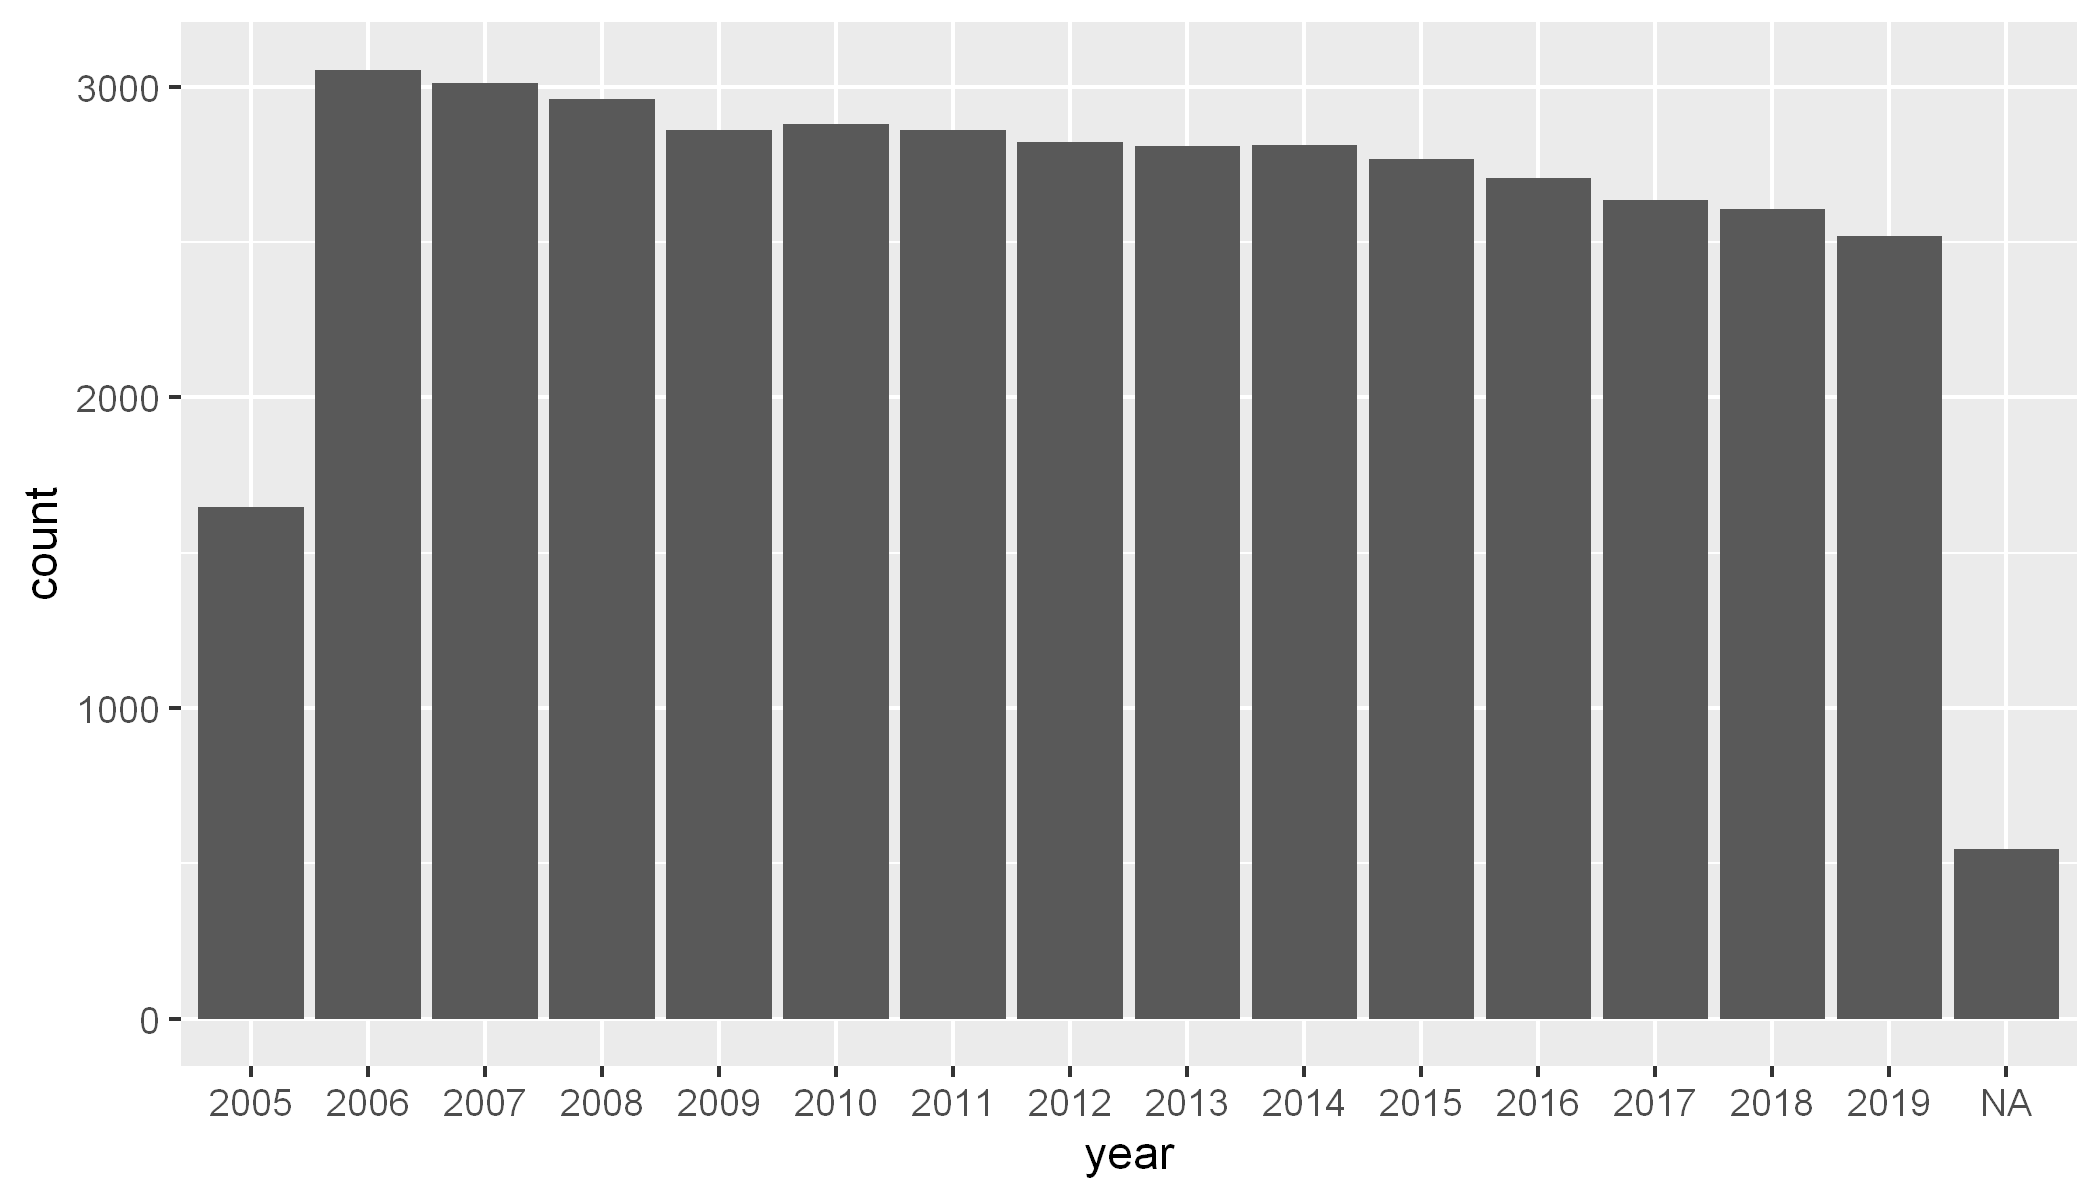

In [4]:
f_sue[, .(year=as.factor(year(rdq1)))] %>%
    ggplot(aes(x=year)) +
    geom_bar() + 
    scale_x_discrete('year')

## `sue` <-> `call_releaes_link`

> Task: merge with `call_release_link`
- `abs(rdq-release_date)<=1`

- Output: `f_sue_tmp`
    - n_obs of `f_sue_tmp` is larger than that of `f_sue` because in `call_release_link` there exist multiple `call_keydevid` for the SAME `release_keydevid`
    - e.g. `ciq_wrds_keydev[keydevid %in% c(404527363, 404314219, 404314224)]`

In [5]:
ld(call_release_link, force=T)
ld(f_sue)

f_sue_keydevid = copy(f_sue)[, ':='(rdq_original=rdq)
    ][call_release_link, on=.(gvkey, rdq=release_date), roll='nearest', nomatch=NULL
    ][abs(rdq-rdq_original)<=5
    ][, ':='(ciq_release_date=rdq)
    ][, ':='(rdq=NULL)
    ][, ':='(rdq=rdq_original)
    ][, ':='(rdq_original=NULL)
    ][order(gvkey, rdq)]

f_sue_keydevid

-call_release_link- loaded  (0.19 secs)
-f_sue- already exists, will NOT load again!  (0 secs)


gvkey,permno,datadate,fyearq,fqtr,fyr,rdq1,repdats,lagrdq1,leadrdq1,mcap,act,sue,se,sest,price_close,release_keydevid,call_date,call_keydevid,companyname,ciq_release_date,rdq
<chr>,<chr>,<date>,<dbl>,<dbl>,<dbl>,<date>,<date>,<date>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<date>,<dbl>,<chr>,<date>,<date>
001013,50906,2005-04-30,2005,2,10,2005-06-01,2005-06-01,2005-02-28,2005-08-30,1840.0620,0.28,0.0308369119,0.123348018,0.092511106,2.27,1667269,2005-06-01,1602393,ADC Telecommunications Inc.,2005-06-01,2005-06-01
001013,50906,2005-07-31,2005,3,10,2005-08-30,2005-08-30,2005-06-01,2005-12-13,3042.6960,0.28,0.0000000000,0.010711553,0.010711553,26.14,1841696,2005-08-30,1775195,ADC Telecommunications Inc.,2005-08-30,2005-08-30
001013,50906,2005-10-31,2005,4,10,2005-12-13,2005-12-13,2005-08-30,2006-03-01,2032.9250,0.18,0.0000000000,0.010315186,0.010315186,17.45,2477236,2005-12-13,2420262,ADC Telecommunications Inc.,2005-12-13,2005-12-13
001013,50906,2006-01-31,2006,1,10,2006-03-01,2006-03-01,2005-12-13,2006-05-31,2967.1200,0.09,0.0000000000,0.003548896,0.003548896,25.36,2666738,2006-03-01,2558193,ADC Telecommunications Inc.,2006-03-01,2006-03-01
001013,50906,2006-04-30,2006,2,10,2006-05-31,2006-05-31,2006-03-01,2006-08-29,2624.1080,0.29,0.0004466280,0.012952211,0.012505583,22.39,2934098,2006-05-31,2850757,ADC Telecommunications Inc.,2006-05-31,2006-05-31
001013,50906,2006-07-31,2006,3,10,2006-08-29,2006-08-29,2006-05-31,2006-12-12,1433.3560,0.30,0.0032706460,0.024529845,0.021259199,12.23,3134011,2006-08-29,3069472,ADC Telecommunications Inc.,2006-08-29,2006-08-29
001013,50906,2006-10-31,2006,4,10,2006-12-12,2006-12-12,2006-08-29,2007-03-05,1677.1320,0.19,0.0017470300,0.013277428,0.011530398,14.31,3363245,2006-12-12,3281344,ADC Telecommunications Inc.,2006-12-12,2006-12-12
001013,50906,2007-01-31,2007,1,10,2007-03-05,2007-03-05,2006-12-12,2007-06-06,1891.6080,0.15,0.0061957869,0.009293680,0.003097893,16.14,3626464,2007-03-05,3473077,ADC Telecommunications Inc.,2007-03-05,2007-03-05
001013,50906,2007-04-30,2007,2,10,2007-06-06,2007-06-06,2007-03-05,2007-09-06,2158.3200,0.35,0.0070652174,0.019021739,0.011956522,18.40,4381097,2007-06-06,4135300,ADC Telecommunications Inc.,2007-06-06,2007-06-06


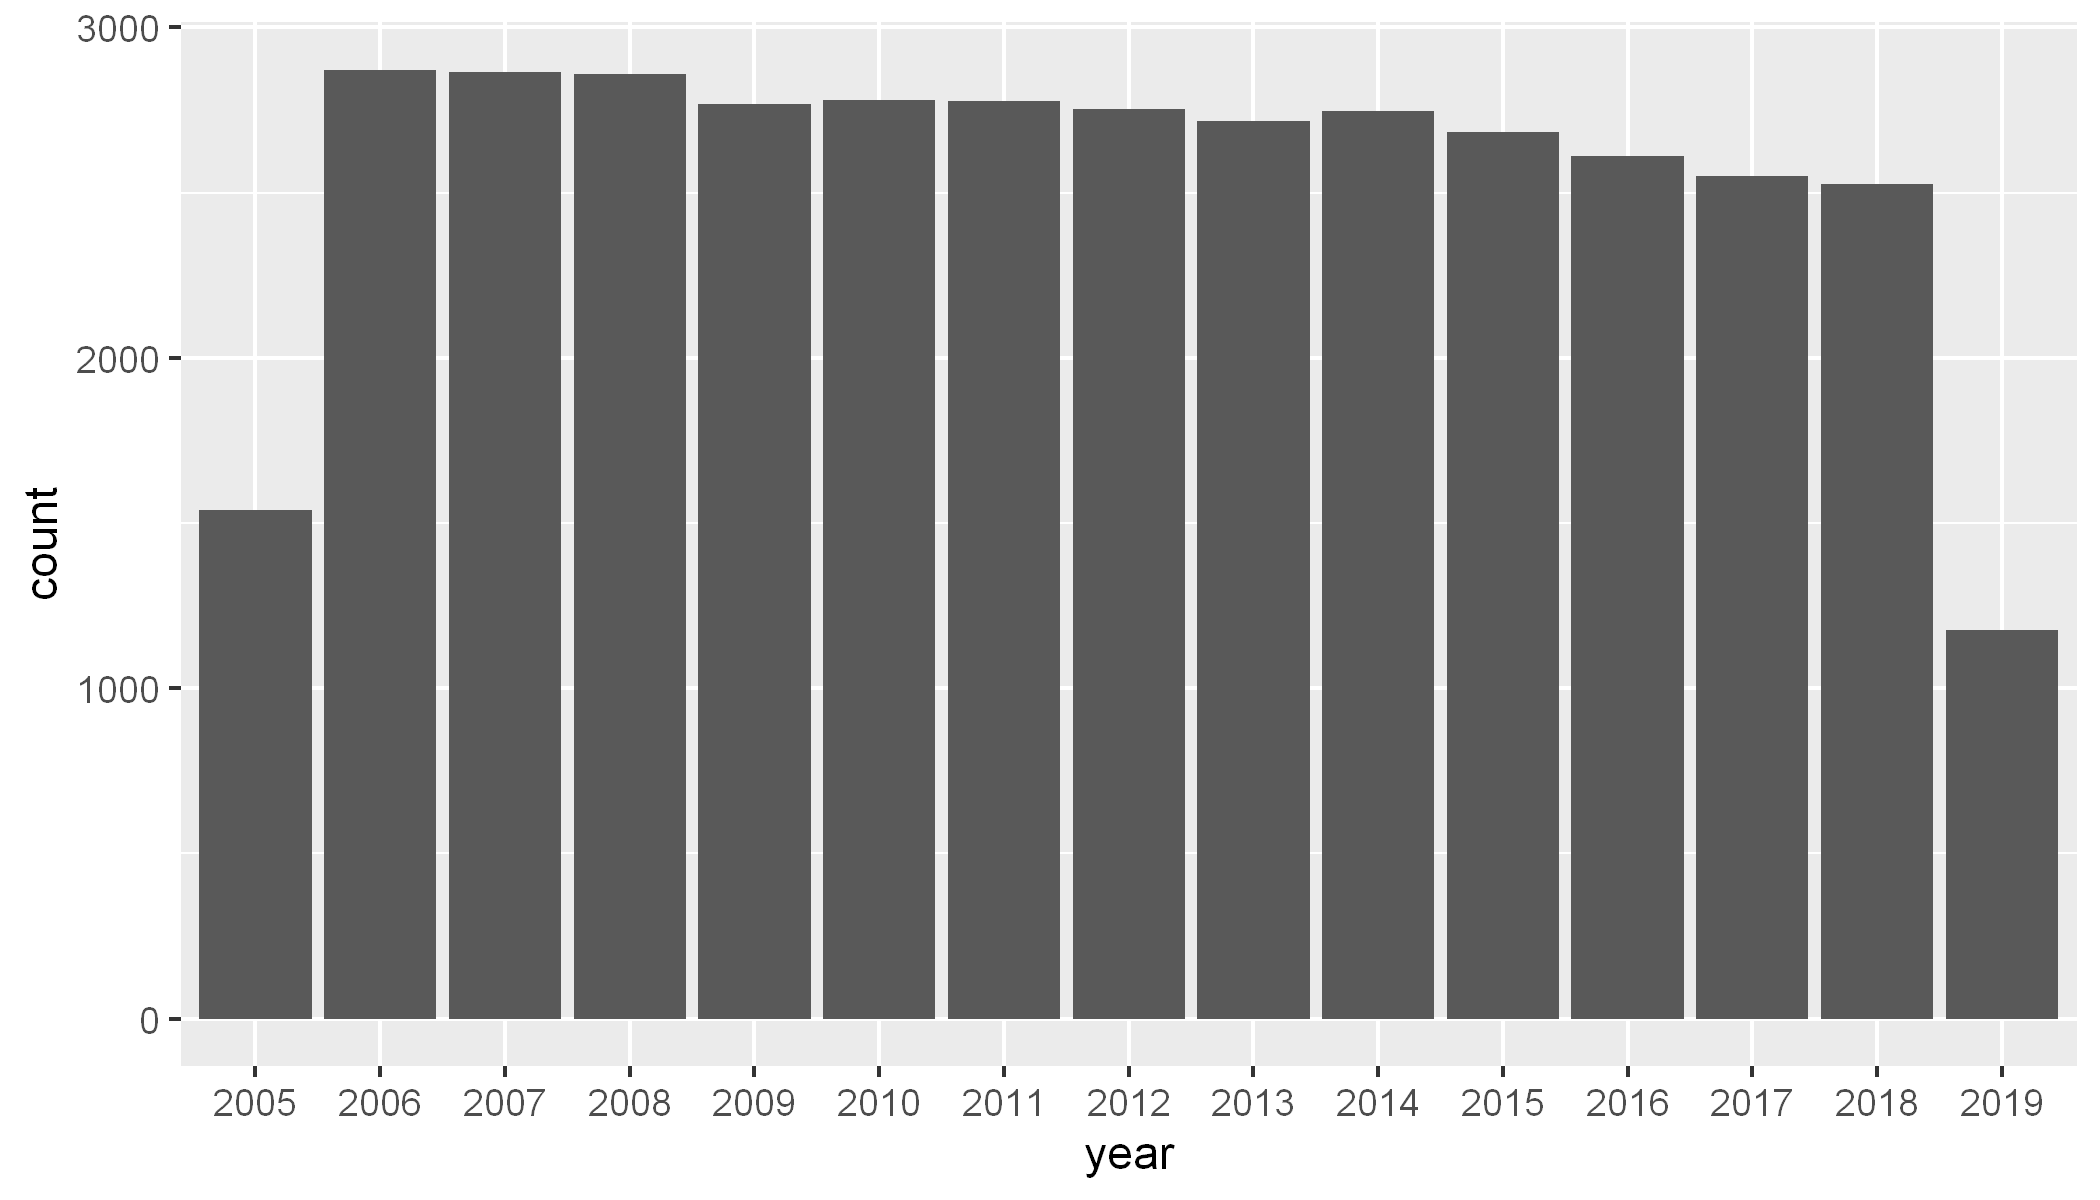

In [6]:
f_sue_keydevid[, .(year=as.factor(year(ciq_release_date)))] %>%
    ggplot(aes(x=year)) +
    geom_bar() + 
    scale_x_discrete('year')

## <-> `car`

> Task: merge with `CAR`
- Warning: `car:edate` is the date of *earnings call*, not earnings announcement. Please use `f_sue_keydev:call_date` as a foreigh key 
- `car` also includes `alpha`, `beta` and `volatility`

In [7]:
ld(car)

-car- loaded  (0.02 secs)


In [8]:
copy(f_sue_keydevid)[, ':='(call_date_original=call_date)
    ][car, on=.(permno, call_date=edate), roll='nearest', nomatch=NULL
    ][abs(call_date-call_date_original)<=5
    ][, ':='(call_date=NULL)
    ][, ':='(call_date=call_date_original)
    ][, ':='(call_date_original=NULL)
    ][]

gvkey,permno,datadate,fyearq,fqtr,fyr,rdq1,repdats,lagrdq1,leadrdq1,mcap,act,sue,se,sest,price_close,release_keydevid,call_keydevid,companyname,ciq_release_date,rdq,car_m1_m1,car_m2_m2,car_m30_m3,car_0_1,car_0_30,alpha,beta_mktrf,beta_smb,beta_hml,volatility,call_date
<chr>,<chr>,<date>,<dbl>,<dbl>,<dbl>,<date>,<date>,<date>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<date>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<date>
012136,10078,2005-06-30,2005,4,6,2005-07-26,2005-07-26,2005-04-14,2005-11-01,12711.84,-0.02,-0.0080428954,-0.005361930,0.002680965,3.730,1770320,1553988,"Oracle America, Inc.",2005-07-26,2005-07-26,-0.0014335116,0.0140835409,0.108810861,-0.0017865447,0.0963175933,-2.734571e-03,1.9318610,-1.225458215,-0.564631167,0.02301963,2005-07-26
012136,10078,2005-09-30,2006,1,6,2005-11-01,2005-11-01,2005-07-26,2006-01-24,13418.01,-0.01,0.0000000000,-0.002544529,-0.002544529,3.930,2386783,2391065,"Oracle America, Inc.",2005-11-01,2005-11-01,-0.0344009746,0.0221500752,0.016033120,0.0001696529,0.1007820085,-4.983900e-04,1.3432966,-0.457905646,-0.006908059,0.01732331,2005-11-02
012136,10078,2005-12-31,2006,2,6,2006-01-24,2006-01-24,2005-11-01,2006-04-24,14501.56,-0.07,-0.0143198091,-0.016706444,-0.002386635,4.190,2553182,2523634,"Oracle America, Inc.",2006-01-24,2006-01-24,-0.0213340807,-0.0330988524,0.131751990,0.0064666575,-0.0288471325,4.749631e-04,0.7662320,0.248810900,-0.257451318,0.01711905,2006-01-24
012136,10078,2006-03-31,2006,3,6,2006-04-24,2006-04-24,2006-01-24,2006-07-25,17943.31,-0.06,0.0000000000,-0.011695906,-0.011695906,5.130,2816006,2713190,"Oracle America, Inc.",2006-04-24,2006-04-24,-0.0186899212,0.0176293678,0.041416552,0.0196056020,-0.0571025489,1.115492e-03,1.1313801,0.033355036,-1.018746480,0.02159686,2006-04-24
012136,10078,2006-06-30,2006,4,6,2006-07-25,2006-07-25,2006-04-24,2006-10-26,14537.45,-0.02,0.0000000000,-0.004819277,-0.004819277,4.150,3052591,2999520,"Oracle America, Inc.",2006-07-25,2006-07-25,0.0212816255,-0.0128487528,-0.033526290,0.0589001038,0.1407188435,9.907481e-04,1.1052516,0.299232240,-1.106265006,0.02111381,2006-07-25
012136,10078,2006-09-30,2007,1,6,2006-10-26,2006-10-26,2006-07-25,2007-01-23,17824.95,-0.01,0.0040404040,-0.002020202,-0.006060606,4.950,3255753,3241098,"Oracle America, Inc.",2006-10-26,2006-10-26,0.0204069298,-0.0061598462,-0.095811229,0.0403055003,0.0124151970,1.734138e-03,1.0418174,0.308903342,-1.223266892,0.02096839,2006-10-26
012136,10078,2006-12-31,2007,2,6,2007-01-23,2007-01-23,2006-10-26,2007-04-24,19516.08,0.04,0.0055350554,0.007380074,0.001845018,5.420,3436166,3409758,"Oracle America, Inc.",2007-01-23,2007-01-23,0.0062429908,-0.0087016250,0.036565256,0.0521339946,0.0626693595,1.433785e-03,1.2713855,0.090716214,-1.089955275,0.01963712,2007-01-23
012136,10078,2007-03-31,2007,3,6,2007-04-24,2007-04-24,2007-01-23,2007-07-30,21359.54,0.01,-0.0016638935,0.001663894,0.003327787,6.010,4030555,3876655,"Oracle America, Inc.",2007-04-24,2007-04-24,-0.0021323832,-0.0058046796,-0.152701448,-0.1209722275,-0.2272562966,1.446116e-03,1.1962412,0.363093187,-0.557511150,0.01813256,2007-04-24
012136,10078,2007-06-30,2007,4,6,2007-07-30,2007-07-30,2007-04-24,2007-11-05,18588.84,0.09,0.0076045627,0.017110266,0.009505703,5.260,4666197,4536831,"Oracle America, Inc.",2007-07-30,2007-07-30,0.0057040574,-0.0276660616,0.033378002,0.0404165232,0.1546665006,-1.159643e-03,0.9864634,0.276275583,-1.093737151,0.02038189,2007-07-30


In [47]:
f_sue_keydevid_car = copy(f_sue_keydevid)[, ':='(call_date_original=call_date)
    ][car, on=.(permno, call_date=edate), roll='nearest', nomatch=NULL
    ][abs(call_date-call_date_original)<=5
    ][, ':='(call_date=NULL)
    ][, ':='(call_date=call_date_original)
    ][, ':='(call_date_original=NULL)
    ][, {
      res = list()
      for (i in 1:.N) {
          leadrdq1_tmp = leadrdq1[i]
          lagrdq1_tmp = lagrdq1[i]
          lead_selector=fillna(rdq1==leadrdq1_tmp, na.value=F)
          lag_selector=fillna(rdq1==lagrdq1_tmp, na.value=F)
          if ((sum(lead_selector)==1) & (sum(lag_selector)==1)) {
              se_lead1 = se[lead_selector]
              se_lag1 = se[lag_selector]
              sue_lag1 = sue[lag_selector]
              sue_lead1 = sue[lead_selector]
              sest_lead1 = sest[lead_selector]
              sest_lag1 = sest[lag_selector]
              car_0_30_lag1 = car_0_30[lag_selector]
              
              res[[i]] = list(permno=permno[i], datadate=datadate[i], fyearq=fyearq[i], fqtr=fqtr[i],
                              fyr=fyr[i], rdq=rdq[i], rdq1=rdq1[i], repdats=repdats[i], ciq_release_date=ciq_release_date[i], call_date=call_date[i],
                              leadrdq1=leadrdq1[i], release_keydevid=release_keydevid[i],
                              call_keydevid=call_keydevid[i], companyname=companyname[i],
                              mcap=mcap[i], sue=sue[i], sue_lag1=sue_lag1, sue_lead1=sue_lead1,
                              se=se[i], se_lag1=se_lag1, se_lead1=se_lead1, 
                              sest=sest[i], sest_lag1=sest_lag1, sest_lead1=sest_lead1,
                              car_m1_m1=car_m1_m1[i], car_m2_m2=car_m2_m2[i],
                              car_m30_m3=car_m30_m3[i], car_0_1=car_0_1[i],
                              car_0_30=car_0_30[i], car_0_30_lag1=car_0_30_lag1,
                              alpha=alpha[i], beta_mktrf=beta_mktrf[i], beta_smb=beta_smb[i],
                              beta_hml=beta_hml[i], volatility=volatility[i])   
          }
      }
      res = rbindlist(res)
      }, 
      keyby=.(gvkey)
    ][order(gvkey, ciq_release_date)]
f_sue_keydevid_car

gvkey,permno,datadate,fyearq,fqtr,fyr,rdq,rdq1,repdats,ciq_release_date,call_date,leadrdq1,release_keydevid,call_keydevid,companyname,mcap,sue,sue_lag1,sue_lead1,se,se_lag1,se_lead1,sest,sest_lag1,sest_lead1,car_m1_m1,car_m2_m2,car_m30_m3,car_0_1,car_0_30,car_0_30_lag1,alpha,beta_mktrf,beta_smb,beta_hml,volatility
<chr>,<chr>,<date>,<dbl>,<dbl>,<dbl>,<date>,<date>,<date>,<date>,<date>,<date>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
001013,50906,2005-07-31,2005,3,10,2005-08-30,2005-08-30,2005-08-30,2005-08-30,2005-08-30,2005-12-13,1841696,1775195,ADC Telecommunications Inc.,3042.6960,0.0000000000,0.0308369119,0.0000000000,0.0107115532,0.1233480176,0.0103151862,0.010711553,0.092511106,0.010315186,-0.0024955979,0.0122708650,-0.114806142,-0.089829158,-0.228517897,0.201533407,3.477498e-03,0.9524472,0.42571495,-1.68360436,0.029442001
001013,50906,2005-10-31,2005,4,10,2005-12-13,2005-12-13,2005-12-13,2005-12-13,2005-12-13,2006-03-01,2477236,2420262,ADC Telecommunications Inc.,2032.9250,0.0000000000,0.0000000000,0.0000000000,0.0103151862,0.0107115532,0.0035488959,0.010315186,0.010711553,0.003548896,-0.0124561637,0.0130551388,0.124125473,0.099890601,0.107638464,-0.228517897,3.966335e-04,0.7948735,1.01114092,0.39107371,0.027712316
001013,50906,2006-01-31,2006,1,10,2006-03-01,2006-03-01,2006-03-01,2006-03-01,2006-03-01,2006-05-31,2666738,2558193,ADC Telecommunications Inc.,2967.1200,0.0000000000,0.0000000000,0.0004466280,0.0035488959,0.0103151862,0.0129522108,0.003548896,0.010315186,0.012505583,-0.0200412936,0.0044162983,0.038779063,0.012332859,-0.094184155,0.107638464,-1.662213e-04,1.3953303,0.86783143,0.68913034,0.029103472
001013,50906,2006-04-30,2006,2,10,2006-05-31,2006-05-31,2006-05-31,2006-05-31,2006-05-31,2006-08-29,2934098,2850757,ADC Telecommunications Inc.,2624.1080,0.0004466280,0.0000000000,0.0032706460,0.0129522108,0.0035488959,0.0245298446,0.012505583,0.003548896,0.021259199,-0.0043131467,-0.0096667009,0.007729152,-0.267167332,-0.352150120,-0.094184155,7.067230e-04,1.2847753,0.61996909,0.44132657,0.023581890
001013,50906,2006-07-31,2006,3,10,2006-08-29,2006-08-29,2006-08-29,2006-08-29,2006-08-29,2006-12-12,3134011,3069472,ADC Telecommunications Inc.,1433.3560,0.0032706460,0.0004466280,0.0017470300,0.0245298446,0.0129522108,0.0132774284,0.021259199,0.012505583,0.011530398,0.0128300915,-0.0242250048,0.074345745,-0.054516307,0.120828071,-0.352150120,-2.484883e-03,0.3841824,0.60112005,-1.11173030,0.026237791
001013,50906,2006-10-31,2006,4,10,2006-12-12,2006-12-12,2006-12-12,2006-12-12,2006-12-12,2007-03-05,3363245,3281344,ADC Telecommunications Inc.,1677.1320,0.0017470300,0.0032706460,0.0061957869,0.0132774284,0.0245298446,0.0092936803,0.011530398,0.021259199,0.003097893,0.0154193792,0.0085944199,0.077244324,0.053666976,0.260416551,0.120828071,-2.225641e-03,-0.0149467,-0.22911466,-2.99601120,0.030549281
001013,50906,2007-01-31,2007,1,10,2007-03-05,2007-03-05,2007-03-05,2007-03-05,2007-03-05,2007-06-06,3626464,3473077,ADC Telecommunications Inc.,1891.6080,0.0061957869,0.0017470300,0.0070652174,0.0092936803,0.0132774284,0.0190217391,0.003097893,0.011530398,0.011956522,-0.0220822266,-0.0112657523,0.106586920,0.026969317,0.031873697,0.260416551,5.343141e-04,1.3329694,-0.21881173,-0.71494944,0.021254895
001013,50906,2007-04-30,2007,2,10,2007-06-06,2007-06-06,2007-06-06,2007-06-06,2007-06-06,2007-09-06,4381097,4135300,ADC Telecommunications Inc.,2158.3200,0.0070652174,0.0061957869,0.0072231140,0.0190217391,0.0092936803,0.0197966827,0.011956522,0.003097893,0.012573569,0.0089631689,0.0095234566,-0.196841033,0.041406605,0.094070351,0.031873697,1.606222e-03,1.1638126,0.68889230,-0.88602862,0.017976560
001013,50906,2007-07-31,2007,3,10,2007-09-06,2007-09-06,2007-09-05,2007-09-05,2007-09-05,2007-12-12,4775271,4689293,ADC Telecommunications Inc.,2196.0750,0.0072231140,0.0070652174,0.0043315508,0.0197966827,0.0190217391,0.0160427807,0.01257

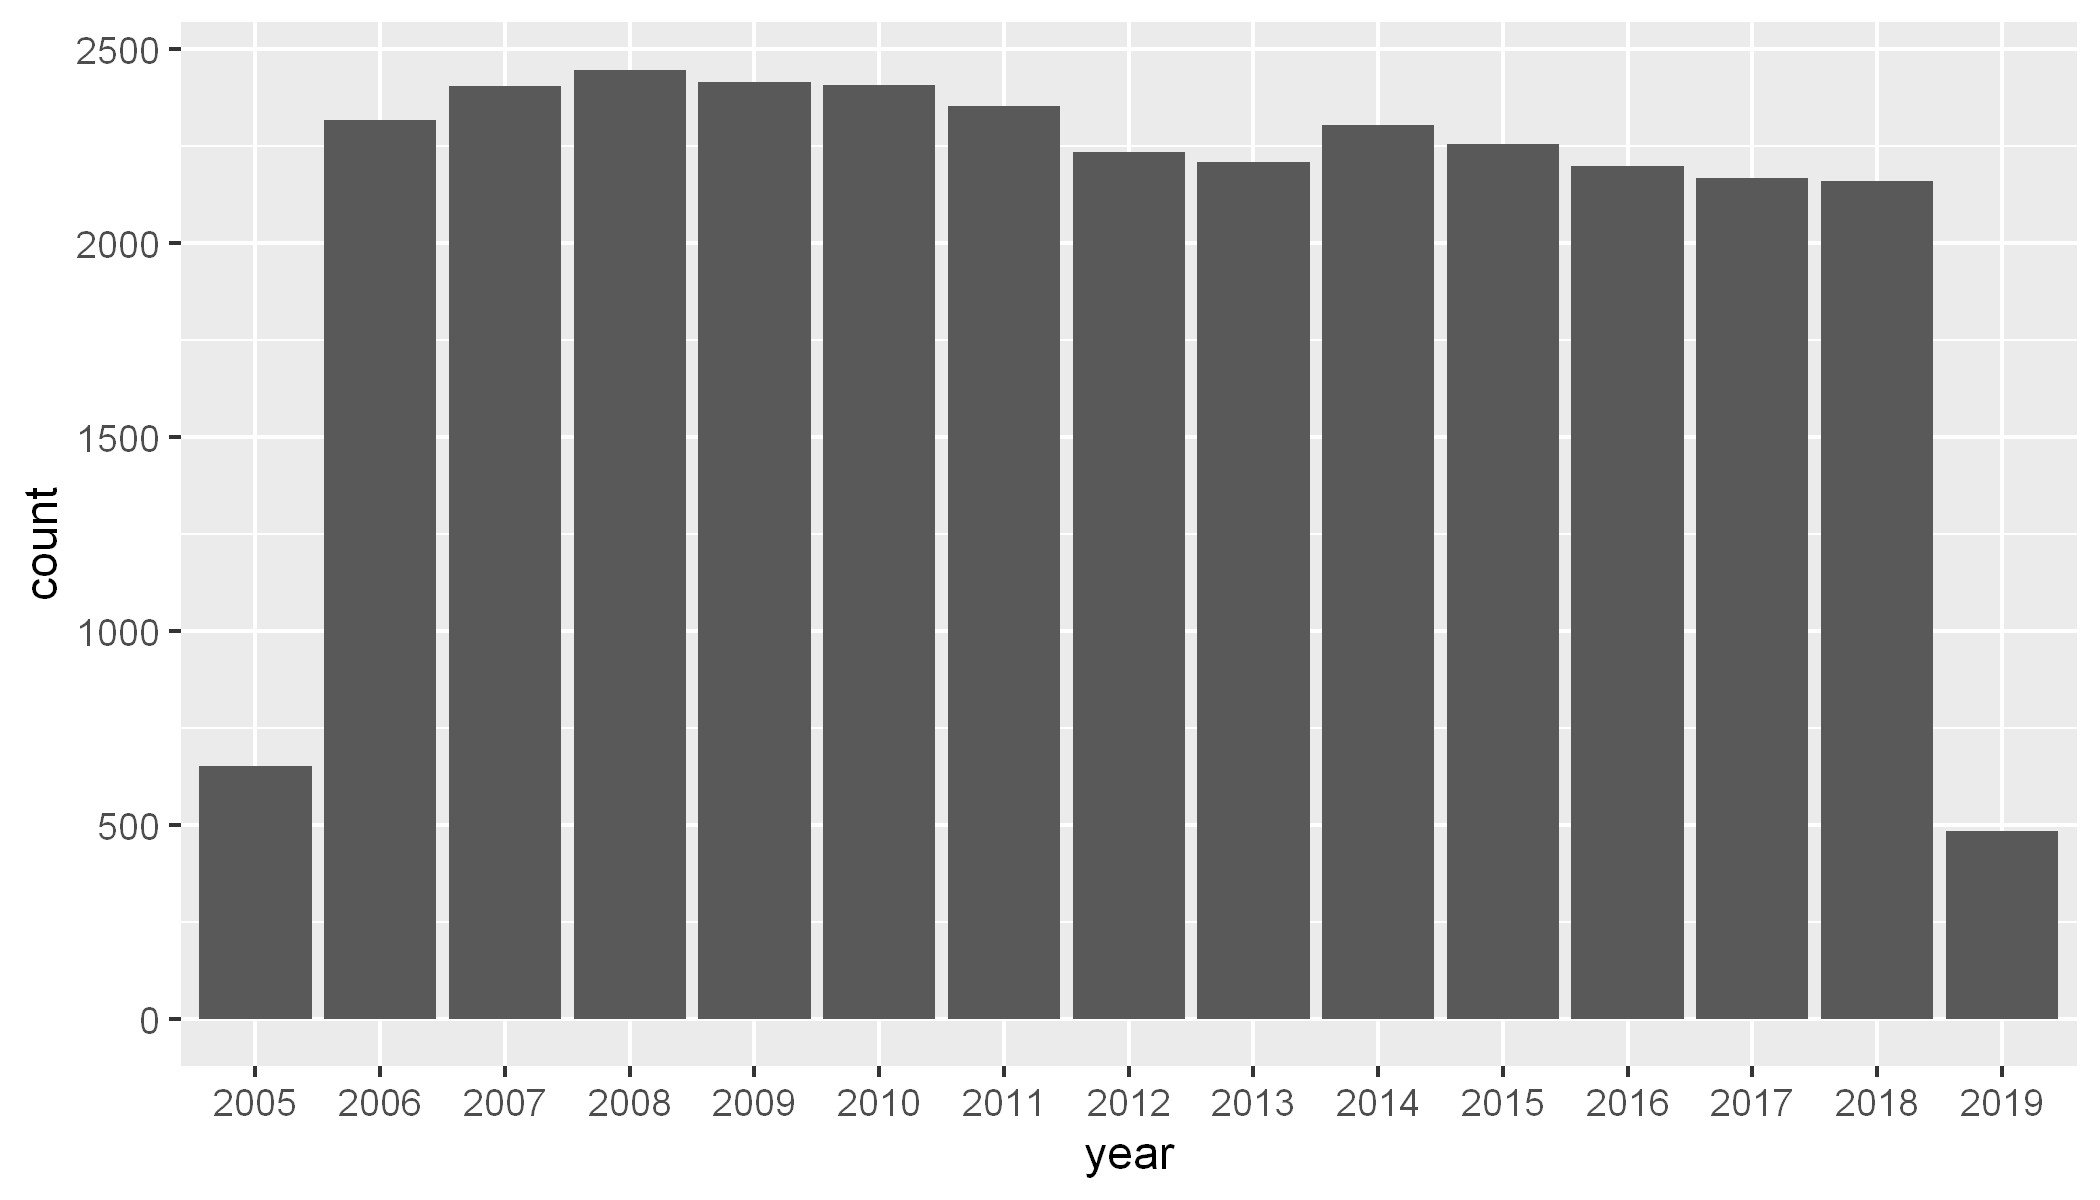

In [48]:
f_sue_keydevid_car[, .(year=as.factor(year(ciq_release_date)))] %>%
    ggplot(aes(x=year)) +
    geom_bar() + 
    scale_x_discrete('year')

## <-> `finratio`

In [65]:
ld(wrds_finratio, path=WRDS_DOWNLOAD_DIR)

-wrds_finratio- already exists, will NOT load again!  (0 secs)


In [66]:
f_sue_keydevid_car_finratio = wrds_finratio[
      f_sue_keydevid_car[, ':='(original_call_date=call_date)],
      on=.(gvkey, public_date=call_date), 
      roll='nearest']
setnames(f_sue_keydevid_car_finratio, 'public_date', 'call_date')

f_sue_keydevid_car_finratio
sv(f_sue_keydevid_car_finratio)

gvkey,adate,qdate,call_date,bm,roa,debt_assets,permno,datadate,fyearq,fqtr,fyr,rdq,rdq1,repdats,ciq_release_date,leadrdq1,release_keydevid,call_keydevid,companyname,mcap,sue,sue_lag1,sue_lead1,se,se_lag1,se_lead1,sest,sest_lag1,sest_lead1,car_m1_m1,car_m2_m2,car_m30_m3,car_0_1,car_0_30,car_0_30_lag1,alpha,beta_mktrf,beta_smb,beta_hml,volatility,original_call_date
<chr>,<date>,<date>,<date>,<dbl>,<dbl>,<dbl>,<chr>,<date>,<dbl>,<dbl>,<dbl>,<date>,<date>,<date>,<date>,<date>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<date>
001013,2004-10-31,2005-04-30,2005-08-30,0.407,0.080,0.525,50906,2005-07-31,2005,3,10,2005-08-30,2005-08-30,2005-08-30,2005-08-30,2005-12-13,1841696,1775195,ADC Telecommunications Inc.,3042.6960,0.0000000000,0.0308369119,0.0000000000,0.0107115532,0.1233480176,0.0103151862,0.010711553,0.092511106,0.010315186,-0.0024955979,0.0122708650,-0.114806142,-0.089829158,-0.228517897,0.201533407,3.477498e-03,0.9524472,0.42571495,-1.68360436,0.029442001,2005-08-30
001013,2004-10-31,2005-07-31,2005-12-13,0.255,0.101,0.507,50906,2005-10-31,2005,4,10,2005-12-13,2005-12-13,2005-12-13,2005-12-13,2006-03-01,2477236,2420262,ADC Telecommunications Inc.,2032.9250,0.0000000000,0.0000000000,0.0000000000,0.0103151862,0.0107115532,0.0035488959,0.010315186,0.010711553,0.003548896,-0.0124561637,0.0130551388,0.124125473,0.099890601,0.107638464,-0.228517897,3.966335e-04,0.7948735,1.01114092,0.39107371,0.027712316,2005-12-13
001013,2005-10-31,2005-10-31,2006-03-01,0.381,0.107,0.496,50906,2006-01-31,2006,1,10,2006-03-01,2006-03-01,2006-03-01,2006-03-01,2006-05-31,2666738,2558193,ADC Telecommunications Inc.,2967.1200,0.0000000000,0.0000000000,0.0004466280,0.0035488959,0.0103151862,0.0129522108,0.003548896,0.010315186,0.012505583,-0.0200412936,0.0044162983,0.038779063,0.012332859,-0.094184155,0.107638464,-1.662213e-04,1.3953303,0.86783143,0.68913034,0.029103472,2006-03-01
001013,2005-10-31,2006-01-31,2006-05-31,0.264,0.110,0.492,50906,2006-04-30,2006,2,10,2006-05-31,2006-05-31,2006-05-31,2006-05-31,2006-08-29,2934098,2850757,ADC Telecommunications Inc.,2624.1080,0.0004466280,0.0000000000,0.0032706460,0.0129522108,0.0035488959,0.0245298446,0.012505583,0.003548896,0.021259199,-0.0043131467,-0.0096667009,0.007729152,-0.267167332,-0.352150120,-0.094184155,7.067230e-04,1.2847753,0.61996909,0.44132657,0.023581890,2006-05-31
001013,2005-10-31,2006-04-30,2006-08-29,0.309,0.102,0.487,50906,2006-07-31,2006,3,10,2006-08-29,2006-08-29,2006-08-29,2006-08-29,2006-12-12,3134011,3069472,ADC Telecommunications Inc.,1433.3560,0.0032706460,0.0004466280,0.0017470300,0.0245298446,0.0129522108,0.0132774284,0.021259199,0.012505583,0.011530398,0.0128300915,-0.0242250048,0.074345745,-0.054516307,0.120828071,-0.352150120,-2.484883e-03,0.3841824,0.60112005,-1.11173030,0.026237791,2006-08-29
001013,2005-10-31,2006-07-31,2006-12-12,0.578,0.098,0.484,50906,2006-10-31,2006,4,10,2006-12-12,2006-12-12,2006-12-12,2006-12-12,2007-03-05,3363245,3281344,ADC Telecommunications Inc.,1677.1320,0.0017470300,0.0032706460,0.0061957869,0.0132774284,0.0245298446,0.0092936803,0.011530398,0.021259199,0.003097893,0.0154193792,0.0085944199,0.077244324,0.053666976,0.260416551,0.120828071,-2.225641e-03,-0.0149467,-0.22911466,-2.99601120,0.030549281,2006-12-12
001013,2006-10-31,2006-10-31,2007-03-05,0.538,0.089,0.458,50906,2007-01-31,2007,1,10,2007-03-05,2007-03-05,2007-03-05,2007-03-05,2007-06-06,3626464,3473077,ADC Telecommunications Inc.,1891.6080,0.0061957869,0.0017470300,0.0070652174,0.0092936803,0.0132774284,0.0190217391,0.003097893,0.011530398,0.011956522,-0.0220822266,-0.0112657523,0.106586920,0.026969317,0.031873697,0.260416551,5.343141e-04,1.3329694,-0.21881173,-0.71494944,0.021254895,2007-03-05
001013,2006-10-31,2007-01-31,2007-06-06,0.465,0.094,0.466,50906,2007-04-30,2007,2,10,2007-06-06,2007-06-06,2007-06-06,2007-06-06,2007-09-06,4381097,4135300,ADC Telecommunications Inc.,2158.3200,

-f_sue_keydevid_car_finratio- saved  (0.38 secs)


## <-> `ciq_transcript_detail`

In [67]:
ld(f_ciq_transcript_detail_sp500, force=T)
ld(f_sue_keydevid_car_finratio, force=T)

-f_ciq_transcript_detail_sp500- loaded  (0.06 secs)
-f_sue_keydevid_car_finratio- loaded  (0.05 secs)


In [104]:
f_sue_keydevid_car_finratio_transcriptid = f_sue_keydevid_car_finratio[
      f_ciq_transcript_detail_sp500[, .(keydevid, transcriptid)], 
      on=.(call_keydevid=keydevid),
      nomatch=NULL
    ][, .(gvkey, permno, datadate, fyear=fyearq, fqtr, ciq_release_date, ciq_call_date=call_date, rdq, rdq1, repdats,
          leadrdq1, release_keydevid, call_keydevid, transcriptid,
          mcap, sue, sue_lag1, sue_lead1, se, se_lag1, se_lead1,
          sest, sest_lag1, sest_lead1, car_m1_m1,
          car_m2_m2, car_m30_m3, car_0_1, car_0_30, car_0_30_lag1,
          bm, roa, debt_asset=debt_assets, alpha, beta_mktrf, beta_smb, beta_hml, volatility)
    ][order(gvkey, ciq_release_date)]

f_sue_keydevid_car_finratio_transcriptid

gvkey,permno,datadate,fyear,fqtr,ciq_release_date,ciq_call_date,rdq,rdq1,repdats,leadrdq1,release_keydevid,call_keydevid,transcriptid,mcap,sue,sue_lag1,sue_lead1,se,se_lag1,se_lead1,sest,sest_lag1,sest_lead1,car_m1_m1,car_m2_m2,car_m30_m3,car_0_1,car_0_30,car_0_30_lag1,bm,roa,debt_asset,alpha,beta_mktrf,beta_smb,beta_hml,volatility
<chr>,<chr>,<date>,<dbl>,<dbl>,<date>,<date>,<date>,<date>,<date>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
001013,50906,2006-04-30,2006,2,2006-05-31,2006-05-31,2006-05-31,2006-05-31,2006-05-31,2006-08-29,2934098,2850757,313,2624.1080,0.0004466280,0.0000000000,0.0032706460,0.0129522108,0.0035488959,0.0245298446,0.0125055828,0.0035488959,0.0212591987,-0.0043131467,-9.666701e-03,0.007729152,-2.671673e-01,-0.352150120,-0.094184155,0.264,0.110,0.492,7.067230e-04,1.2847753,0.61996909,0.44132657,0.023581890
001013,50906,2006-07-31,2006,3,2006-08-29,2006-08-29,2006-08-29,2006-08-29,2006-08-29,2006-12-12,3134011,3069472,314,1433.3560,0.0032706460,0.0004466280,0.0017470300,0.0245298446,0.0129522108,0.0132774284,0.0212591987,0.0125055828,0.0115303983,0.0128300915,-2.422500e-02,0.074345745,-5.451631e-02,0.120828071,-0.352150120,0.309,0.102,0.487,-2.484883e-03,0.3841824,0.60112005,-1.11173030,0.026237791
001013,50906,2006-10-31,2006,4,2006-12-12,2006-12-12,2006-12-12,2006-12-12,2006-12-12,2007-03-05,3363245,3281344,315,1677.1320,0.0017470300,0.0032706460,0.0061957869,0.0132774284,0.0245298446,0.0092936803,0.0115303983,0.0212591987,0.0030978934,0.0154193792,8.594420e-03,0.077244324,5.366698e-02,0.260416551,0.120828071,0.578,0.098,0.484,-2.225641e-03,-0.0149467,-0.22911466,-2.99601120,0.030549281
001013,50906,2007-01-31,2007,1,2007-03-05,2007-03-05,2007-03-05,2007-03-05,2007-03-05,2007-06-06,3626464,3473077,316,1891.6080,0.0061957869,0.0017470300,0.0070652174,0.0092936803,0.0132774284,0.0190217391,0.0030978934,0.0115303983,0.0119565217,-0.0220822266,-1.126575e-02,0.106586920,2.696932e-02,0.031873697,0.260416551,0.538,0.089,0.458,5.343141e-04,1.3329694,-0.21881173,-0.71494944,0.021254895
001013,50906,2007-04-30,2007,2,2007-06-06,2007-06-06,2007-06-06,2007-06-06,2007-06-06,2007-09-06,4381097,4135300,317,2158.3200,0.0070652174,0.0061957869,0.0072231140,0.0190217391,0.0092936803,0.0197966827,0.0119565217,0.0030978934,0.0125735688,0.0089631689,9.523457e-03,-0.196841033,4.140661e-02,0.094070351,0.031873697,0.465,0.094,0.466,1.606222e-03,1.1638126,0.68889230,-0.88602862,0.017976560
001013,50906,2007-07-31,2007,3,2007-09-05,2007-09-05,2007-09-06,2007-09-06,2007-09-05,2007-12-12,4775271,4689293,318,2196.0750,0.0072231140,0.0070652174,0.0043315508,0.0197966827,0.0190217391,0.0160427807,0.0125735688,0.0119565217,0.0117112299,-0.0082603261,1.252027e-02,-0.116792300,8.703108e-02,-0.043799600,0.094070351,0.454,0.098,0.452,1.373025e-03,1.2990013,0.33828924,-0.79375723,0.018213925
001013,50906,2007-10-31,2007,4,2007-12-12,2007-12-12,2007-12-12,2007-12-12,2007-12-12,2008-03-05,5033929,4958486,319,2199.1200,0.0043315508,0.0072231140,0.0067613252,0.0160427807,0.0197966827,0.0189317106,0.0117112299,0.0125735688,0.0121703854,-0.0159378354,-3.857337e-02,-0.077440891,1.390125e-01,-0.151569387,-0.043799600,0.456,0.101,0.440,1.498600e-03,0.9430651,-0.24810023,1.43039740,0.024224106
001013,50906,2008-01-31,2008,1,2008-03-05,2008-03-05,2008-03-05,2008-03-05,2008-03-05,2008-06-04,5241424,5152678,320,1739.3040,0.0067613252,0.0043315508,0.0057061341,0.0189317106,0.0160427807,0.0278174037,0.0121703854,0.0117112299,0.0221112696,0.0079397027,-1.043903e-02,-0.026557246,6.917939e-02,-0.065671969,-0.151569387,0.477,0.099,0.429,-8.592177e-04,0.9685945,-0.29392653,1.24355884,0.031710022
001013,50906,2008-04-30,2008,2,2008-06-04,2008-06-04,2008-06-04,2008-06-04,2008-06-04,2008-09-04,5525351,5425406,322,1650.1540,0.0057061341,0.0067613252,0.0010570825,0.0278174037,0.0189317106,0.0285412262,0.0221112696,0.0121703854,0.0274841438

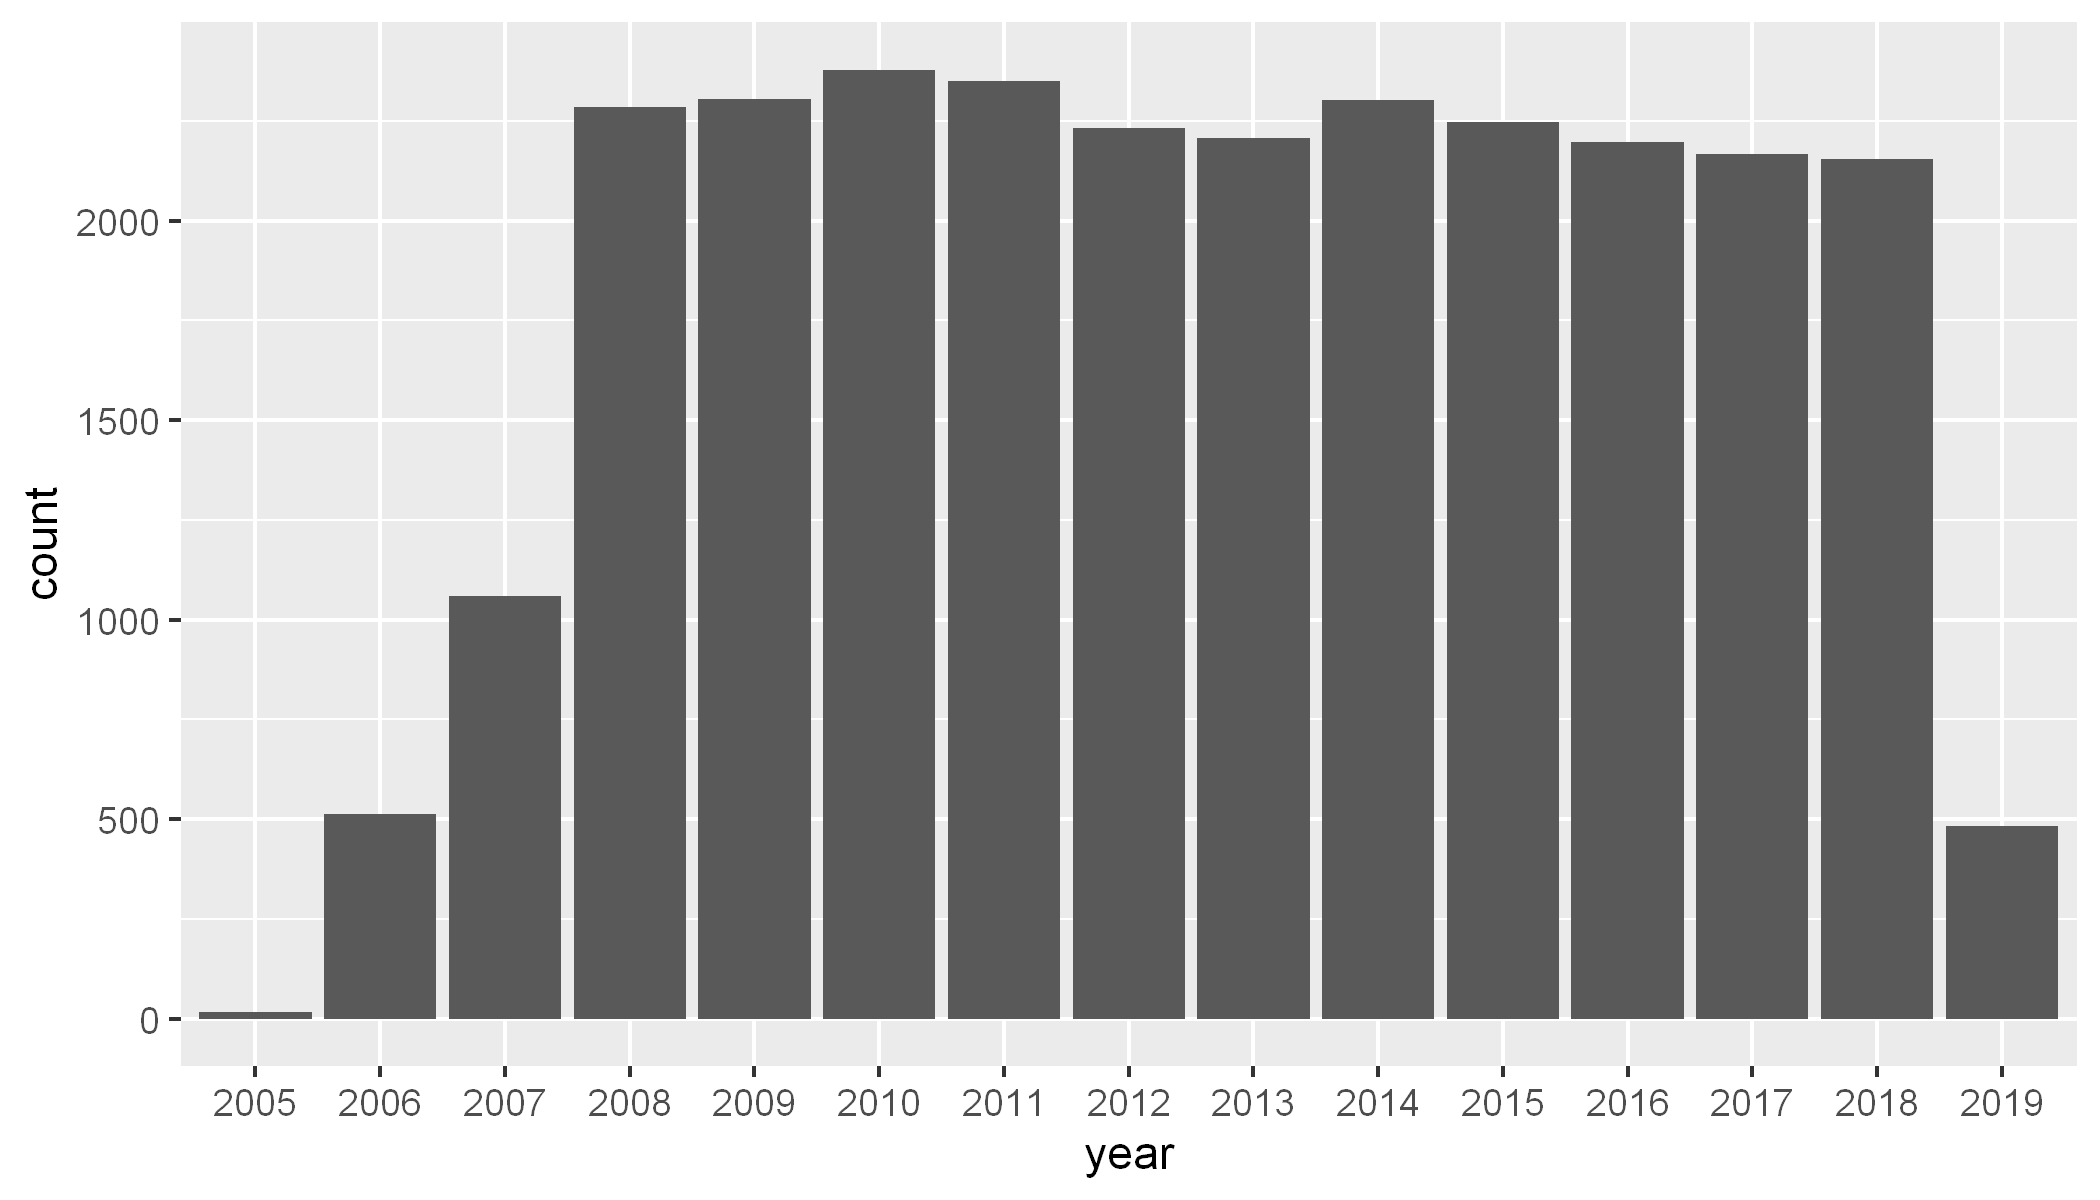

In [105]:
f_sue_keydevid_car_finratio_transcriptid[, .(year=as.factor(year(ciq_release_date)))] %>%
    ggplot(aes(x=year)) +
    geom_bar() + 
    scale_x_discrete('year')

In [106]:
sv(f_sue_keydevid_car_finratio_transcriptid)

-f_sue_keydevid_car_finratio_transcriptid- saved  (0.32 secs)


## remove outliers

Only remove missing values here. For scaling, do it in Python.

In [107]:
ld(f_sue_keydevid_car_finratio_transcriptid, force=T)

-f_sue_keydevid_car_finratio_transcriptid- loaded  (0.04 secs)


In [108]:
cat('Before removing:', f_sue_keydevid_car_finratio_transcriptid[, .N], '\n')

limit_se = 1
limit_sue = 1
limit_car = 1
limit_sest = 1

f_sue_keydevid_car_finratio_transcriptid_limitoutlier = na.omit(f_sue_keydevid_car_finratio_transcriptid, cols=c('sue', 'se_lead1', 'sest', 'transcriptid', 'release_keydevid', 'call_keydevid', 'car_m1_m1', 'car_m2_m2', 'car_m30_m3', 'car_0_1', 'car_0_30', 'car_0_30_lag1'))[
      se_lead1 < -limit_se, ':='(se_lead1=-limit_se)
    ][se_lead1 > limit_se, ':='(se_lead1=limit_se)
    ][sue < -limit_sue, ':='(sue=-limit_sue)
    ][sue > limit_sue, ':='(sue=limit_sue)
    ][car_0_30 < -limit_car, ':='(car_0_30=-limit_car)
    ][car_0_30 > limit_car, ':='(car_0_30=limit_car)
    ][sest > limit_sest, ':='(sest=limit_sest)
    ][sest < -limit_sest, ':='(sest=-limit_sest)]
#     ][sue %between% c(-limit_sue, limit_sue)
#     ][car %between% c(-limit_car, limit_car)
#     ][se_lead1 %between% c(-limit_se, limit_se)
#     ][sest %between% c(-limit_sest, limit_sest)]
    
cat('After removing:', f_sue_keydevid_car_finratio_transcriptid_limitoutlier[, .N])

Before removing: 26894 
After removing: 26894

In [109]:
f_sue_keydevid_car_finratio_transcriptid_limitoutlier[1]

gvkey,permno,datadate,fyear,fqtr,ciq_release_date,ciq_call_date,rdq,rdq1,repdats,leadrdq1,release_keydevid,call_keydevid,transcriptid,mcap,sue,sue_lag1,sue_lead1,se,se_lag1,se_lead1,sest,sest_lag1,sest_lead1,car_m1_m1,car_m2_m2,car_m30_m3,car_0_1,car_0_30,car_0_30_lag1,bm,roa,debt_asset,alpha,beta_mktrf,beta_smb,beta_hml,volatility
<chr>,<chr>,<date>,<dbl>,<dbl>,<date>,<date>,<date>,<date>,<date>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
001013,50906,2006-04-30,2006,2,2006-05-31,2006-05-31,2006-05-31,2006-05-31,2006-05-31,2006-08-29,2934098,2850757,313,2624.108,0.000446628,0,0.003270646,0.01295221,0.003548896,0.02452984,0.01250558,0.003548896,0.0212592,-0.004313147,-0.009666701,0.007729152,-0.2671673,-0.3521501,-0.09418415,0.264,0.11,0.492,0.000706723,1.284775,0.6199691,0.4413266,0.02358189


In [110]:
sv(f_sue_keydevid_car_finratio_transcriptid_limitoutlier)

-f_sue_keydevid_car_finratio_transcriptid_limitoutlier- saved  (0.32 secs)


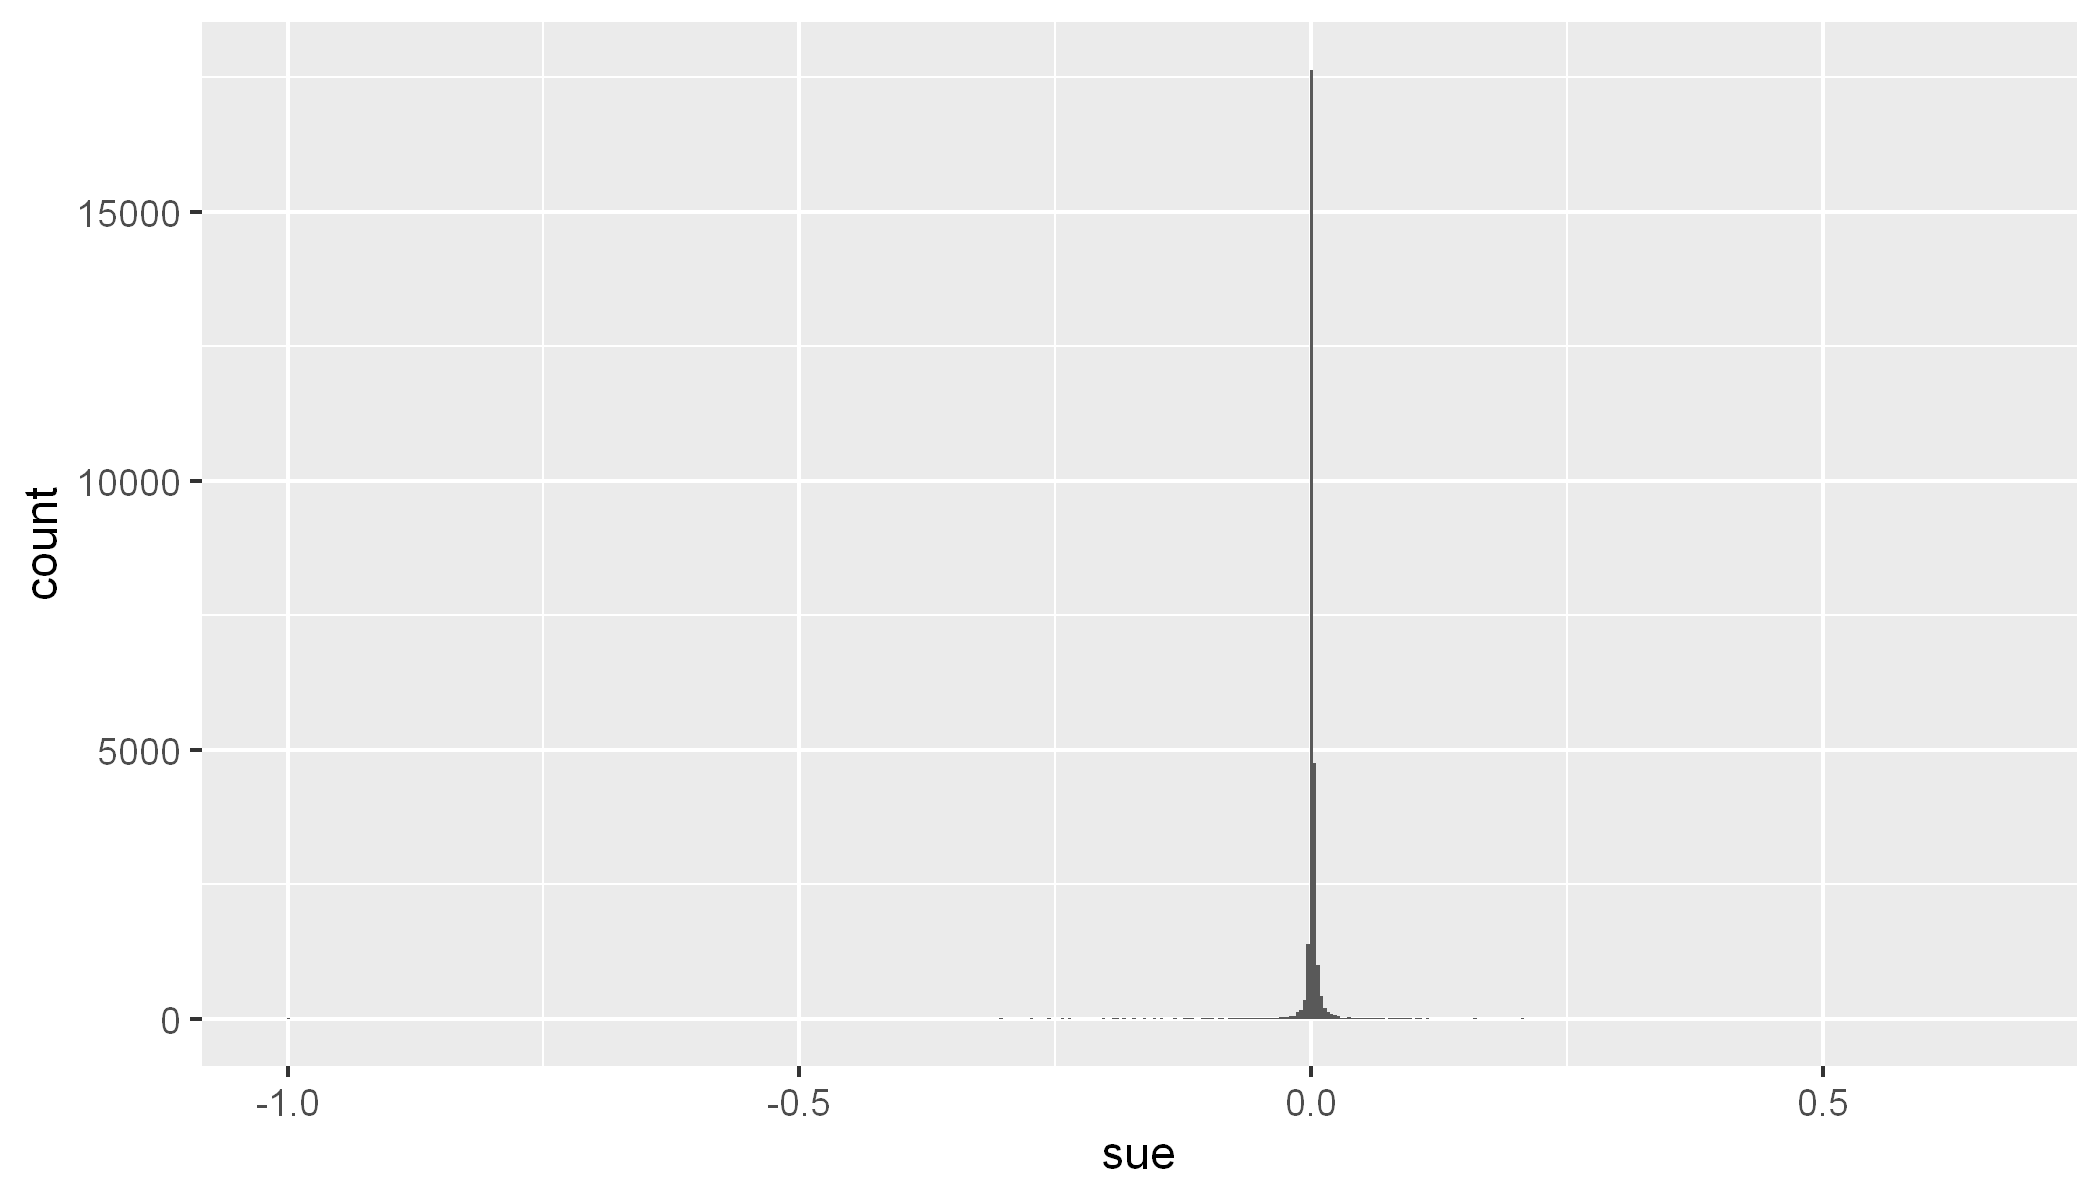

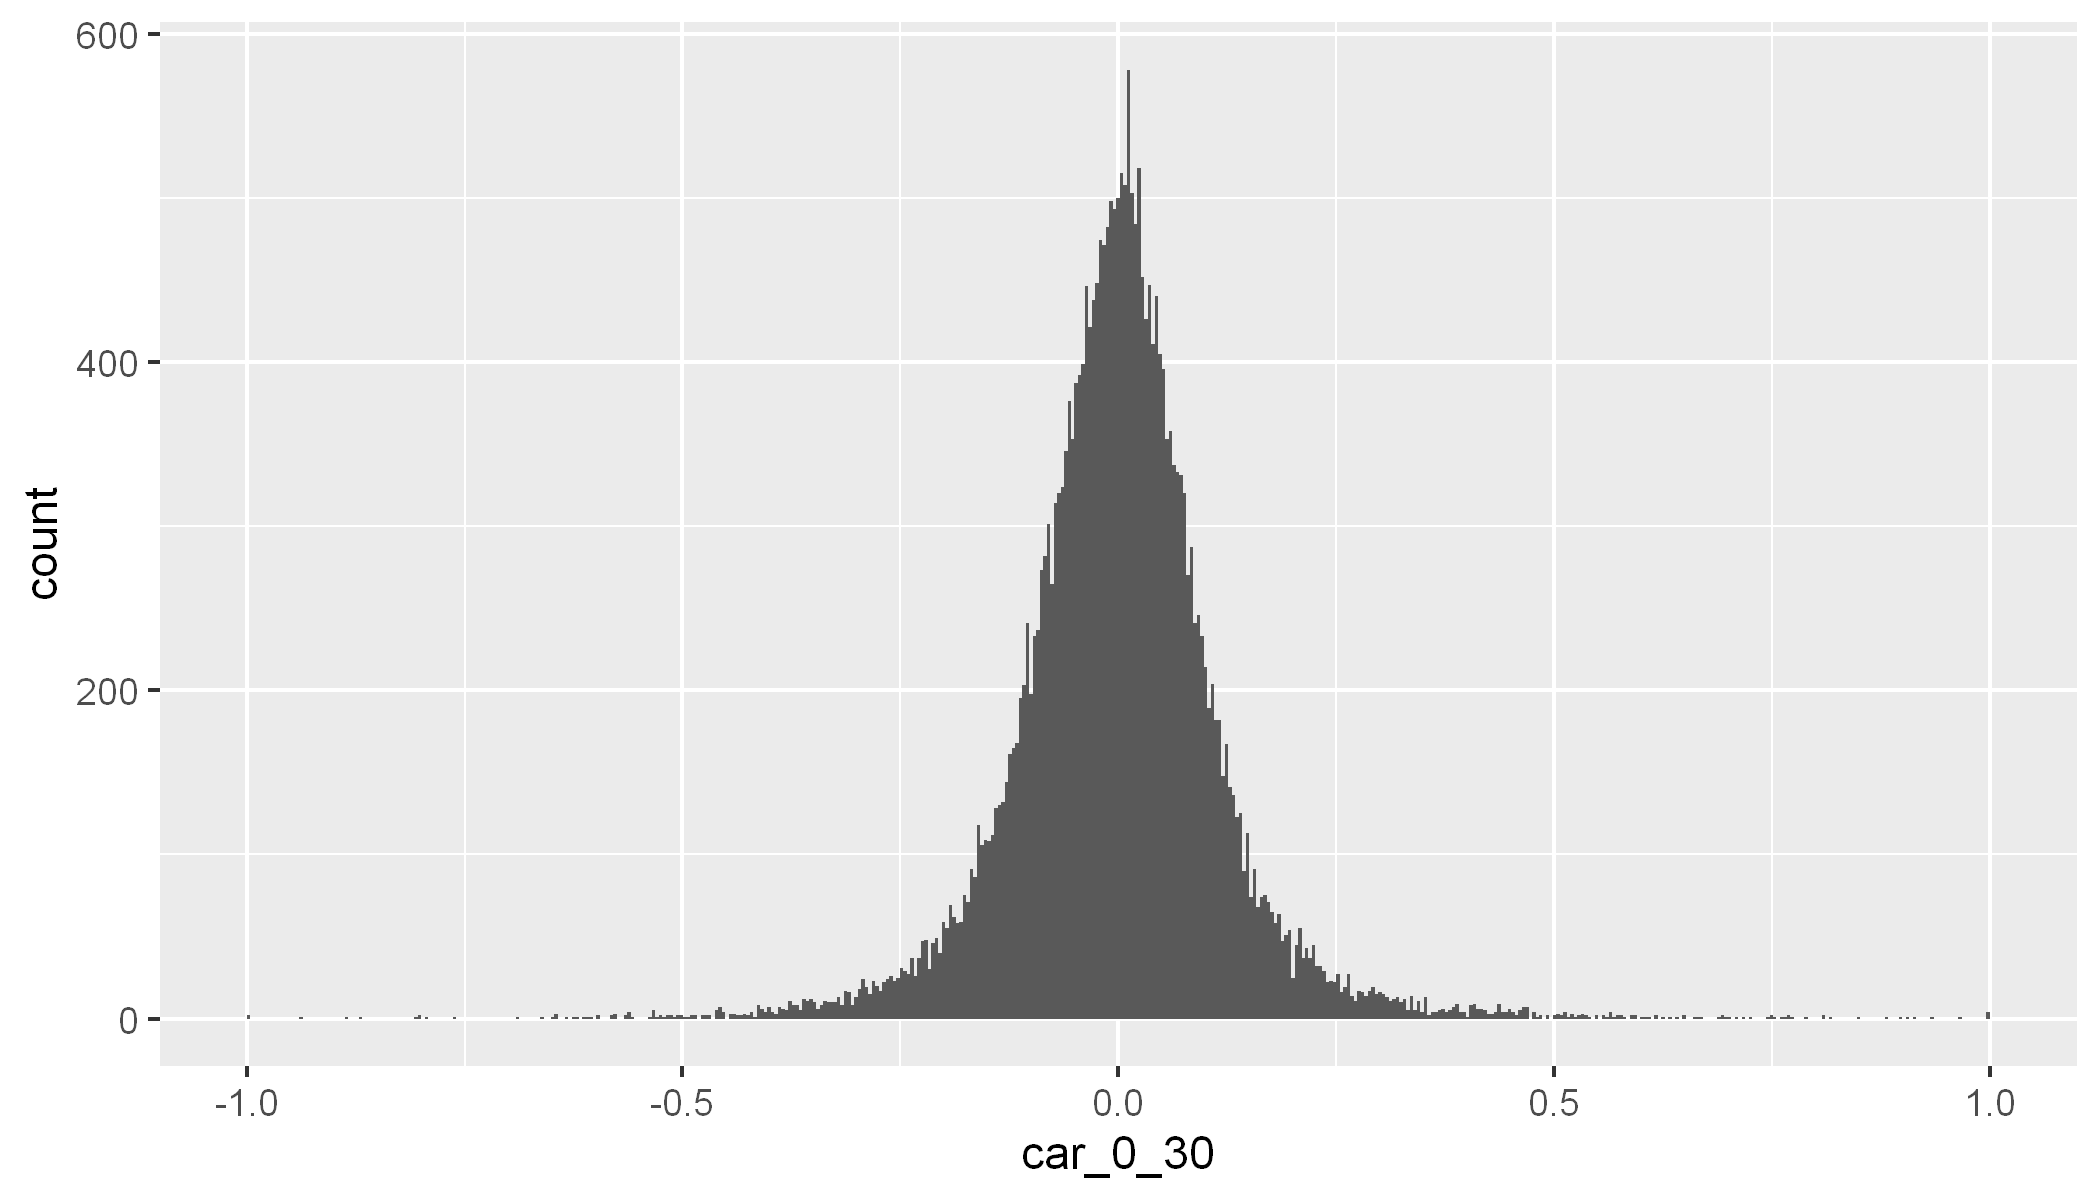

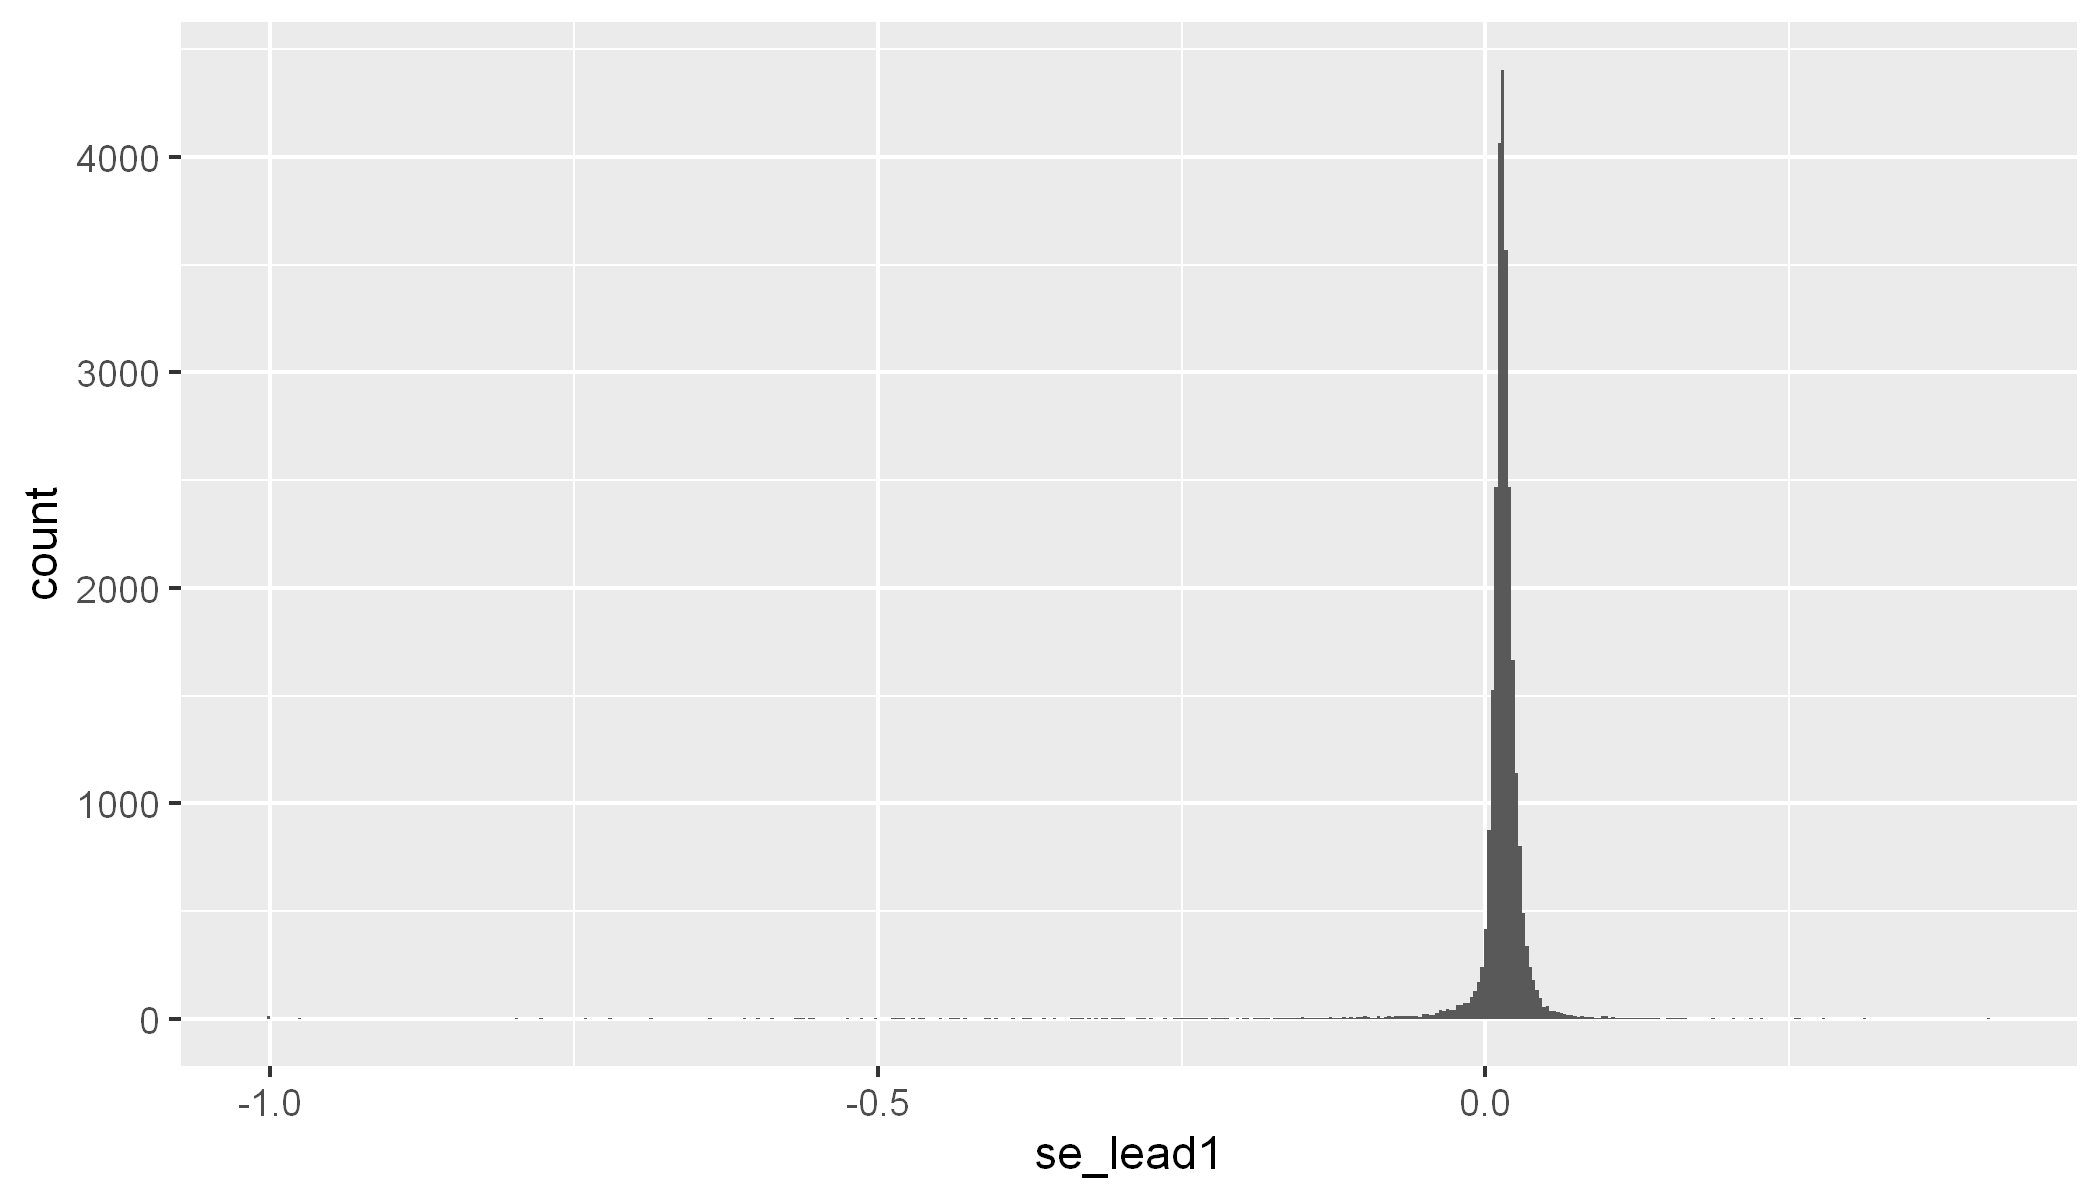

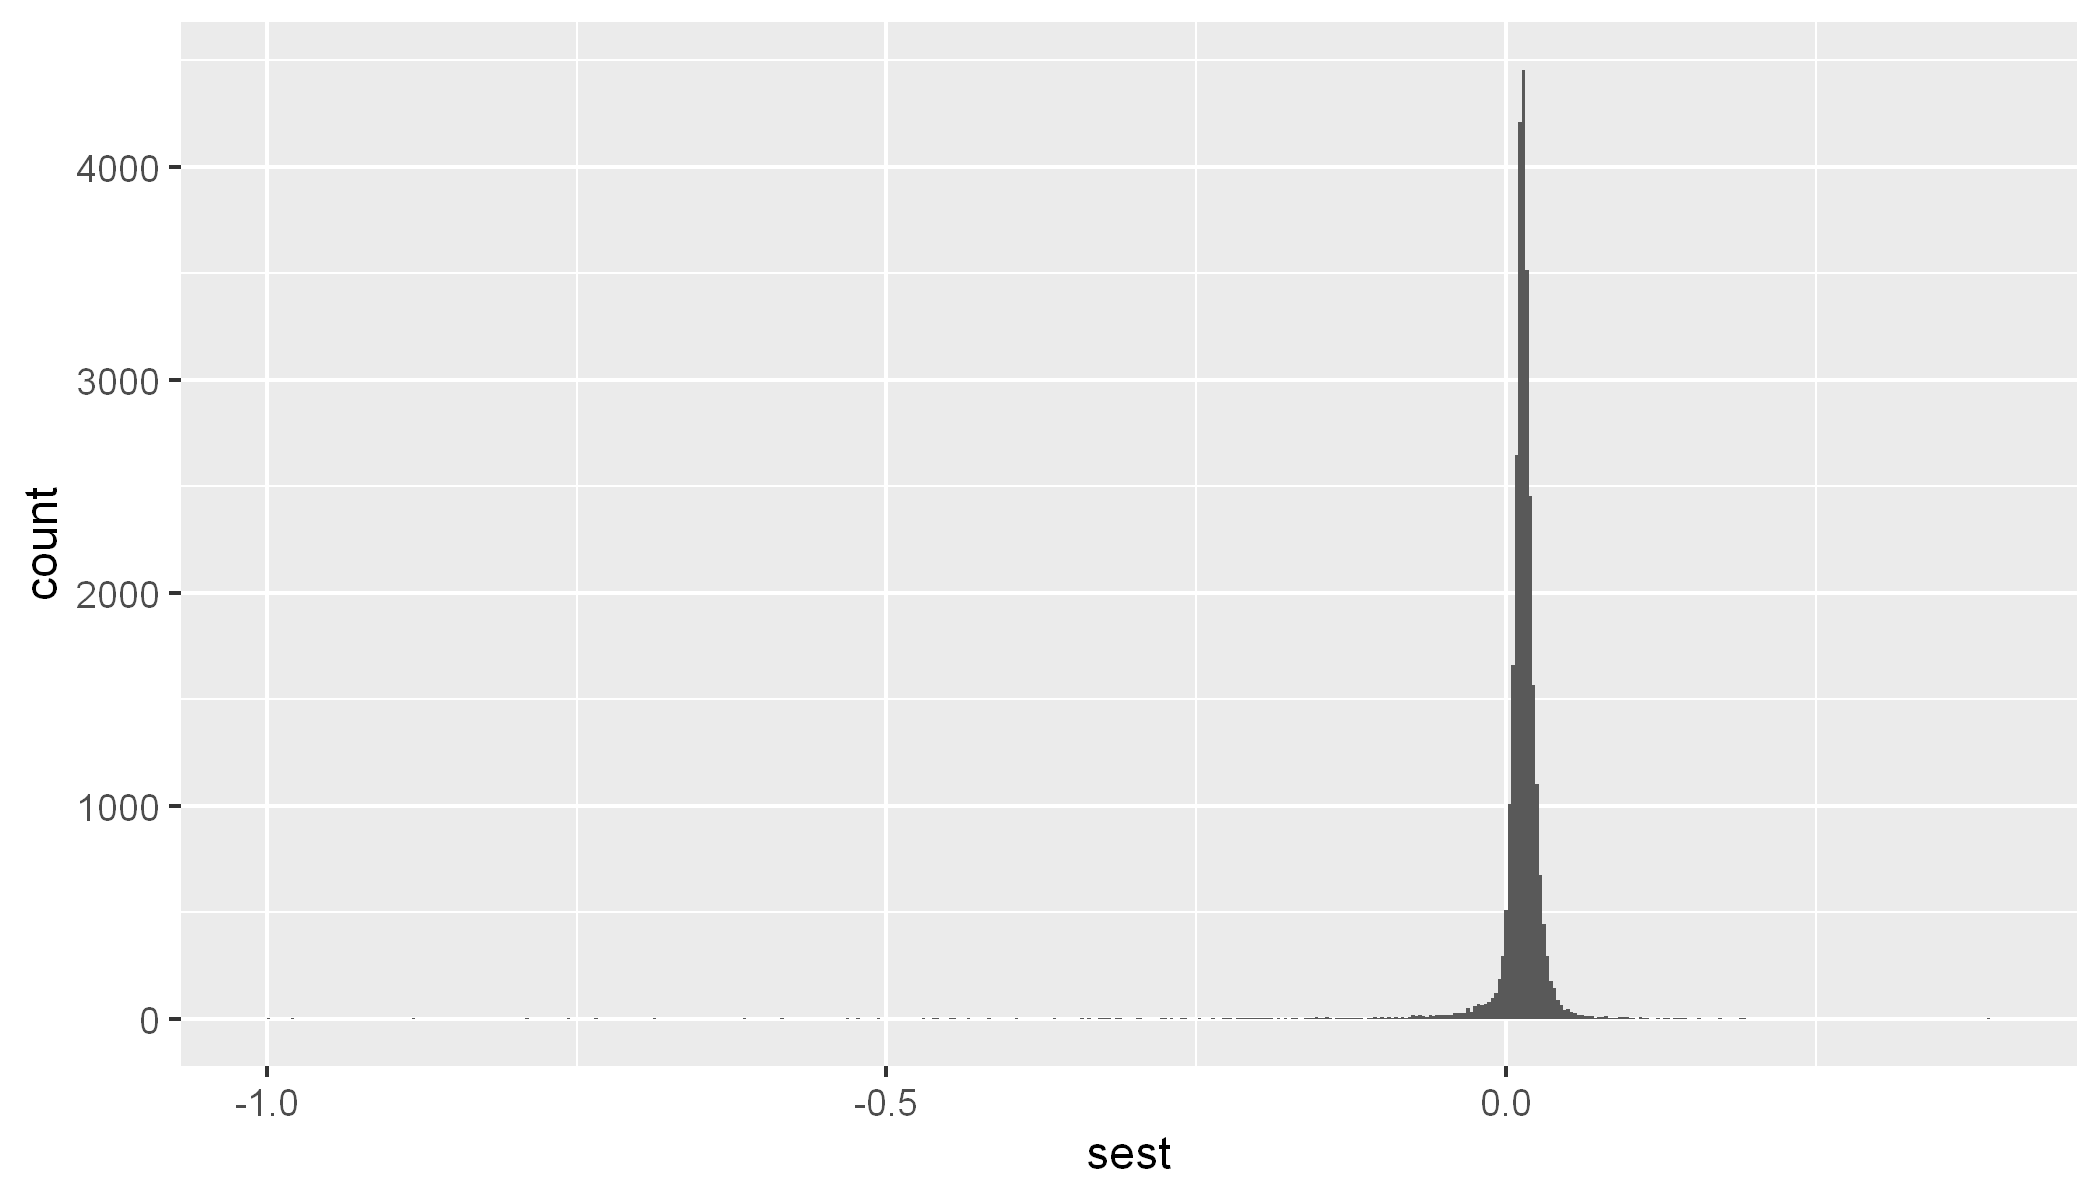

In [111]:
f_sue_keydevid_car_finratio_transcriptid_limitoutlier %>%
    ggplot(aes(x=sue)) + 
    geom_histogram(bins=500)

f_sue_keydevid_car_finratio_transcriptid_limitoutlier %>%
    ggplot(aes(x=car_0_30)) + 
    geom_histogram(bins=500)

f_sue_keydevid_car_finratio_transcriptid_limitoutlier %>%
    ggplot(aes(x=se_lead1)) + 
    geom_histogram(bins=500)

f_sue_keydevid_car_finratio_transcriptid_limitoutlier %>%
    ggplot(aes(x=sest)) + 
    geom_histogram(bins=500)

## <-> `transcripts`

> Task
- add `x_present`, `x_qa`, `x_ans` and `x_ques`

In [5]:
ld(f_sue_keydevid_car_finratio_transcriptid_limitoutlier, force=T)
ld(x_present)
ld(x_qa)
ld(x_ans)
ld(x_ques)
ld(x_all)

-f_sue_keydevid_car_finratio_transcriptid_limitoutlier- loaded  (0.06 secs)
-x_present- loaded  (3.9 secs)
-x_qa- loaded  (5.31 secs)
-x_ans- loaded  (3.96 secs)
-x_ques- loaded  (1.77 secs)
-x_all- already exists, will NOT load again!  (0 secs)


In [6]:
f_sue_keydevid_car_finratio_transcriptid_text = f_sue_keydevid_car_finratio_transcriptid_limitoutlier[
      x_present[, .(transcriptid, text_present=text)], on=.(transcriptid), nomatch=NULL
    ][x_qa[, .(transcriptid, text_qa=text)], on=.(transcriptid), nomatch=NULL
    ][x_ans[, .(transcriptid, text_ans=text)], on=.(transcriptid), nomatch=NULL
    ][x_ques[, .(transcriptid, text_ques=text)], on=.(transcriptid), nomatch=NULL
    ][x_all[, .(transcriptid, text_all=text)], on=.(transcriptid), nomatch=NULL]

f_sue_keydevid_car_finratio_transcriptid_text[, .N]

[1] 26108

In [7]:
sv(f_sue_keydevid_car_finratio_transcriptid_text)

-f_sue_keydevid_car_finratio_transcriptid_text- saved  (2.81 mins)


In [8]:
write_feather(f_sue_keydevid_car_finratio_transcriptid_text, './data/f_sue_keydevid_car_finratio_transcriptid_text.feather')

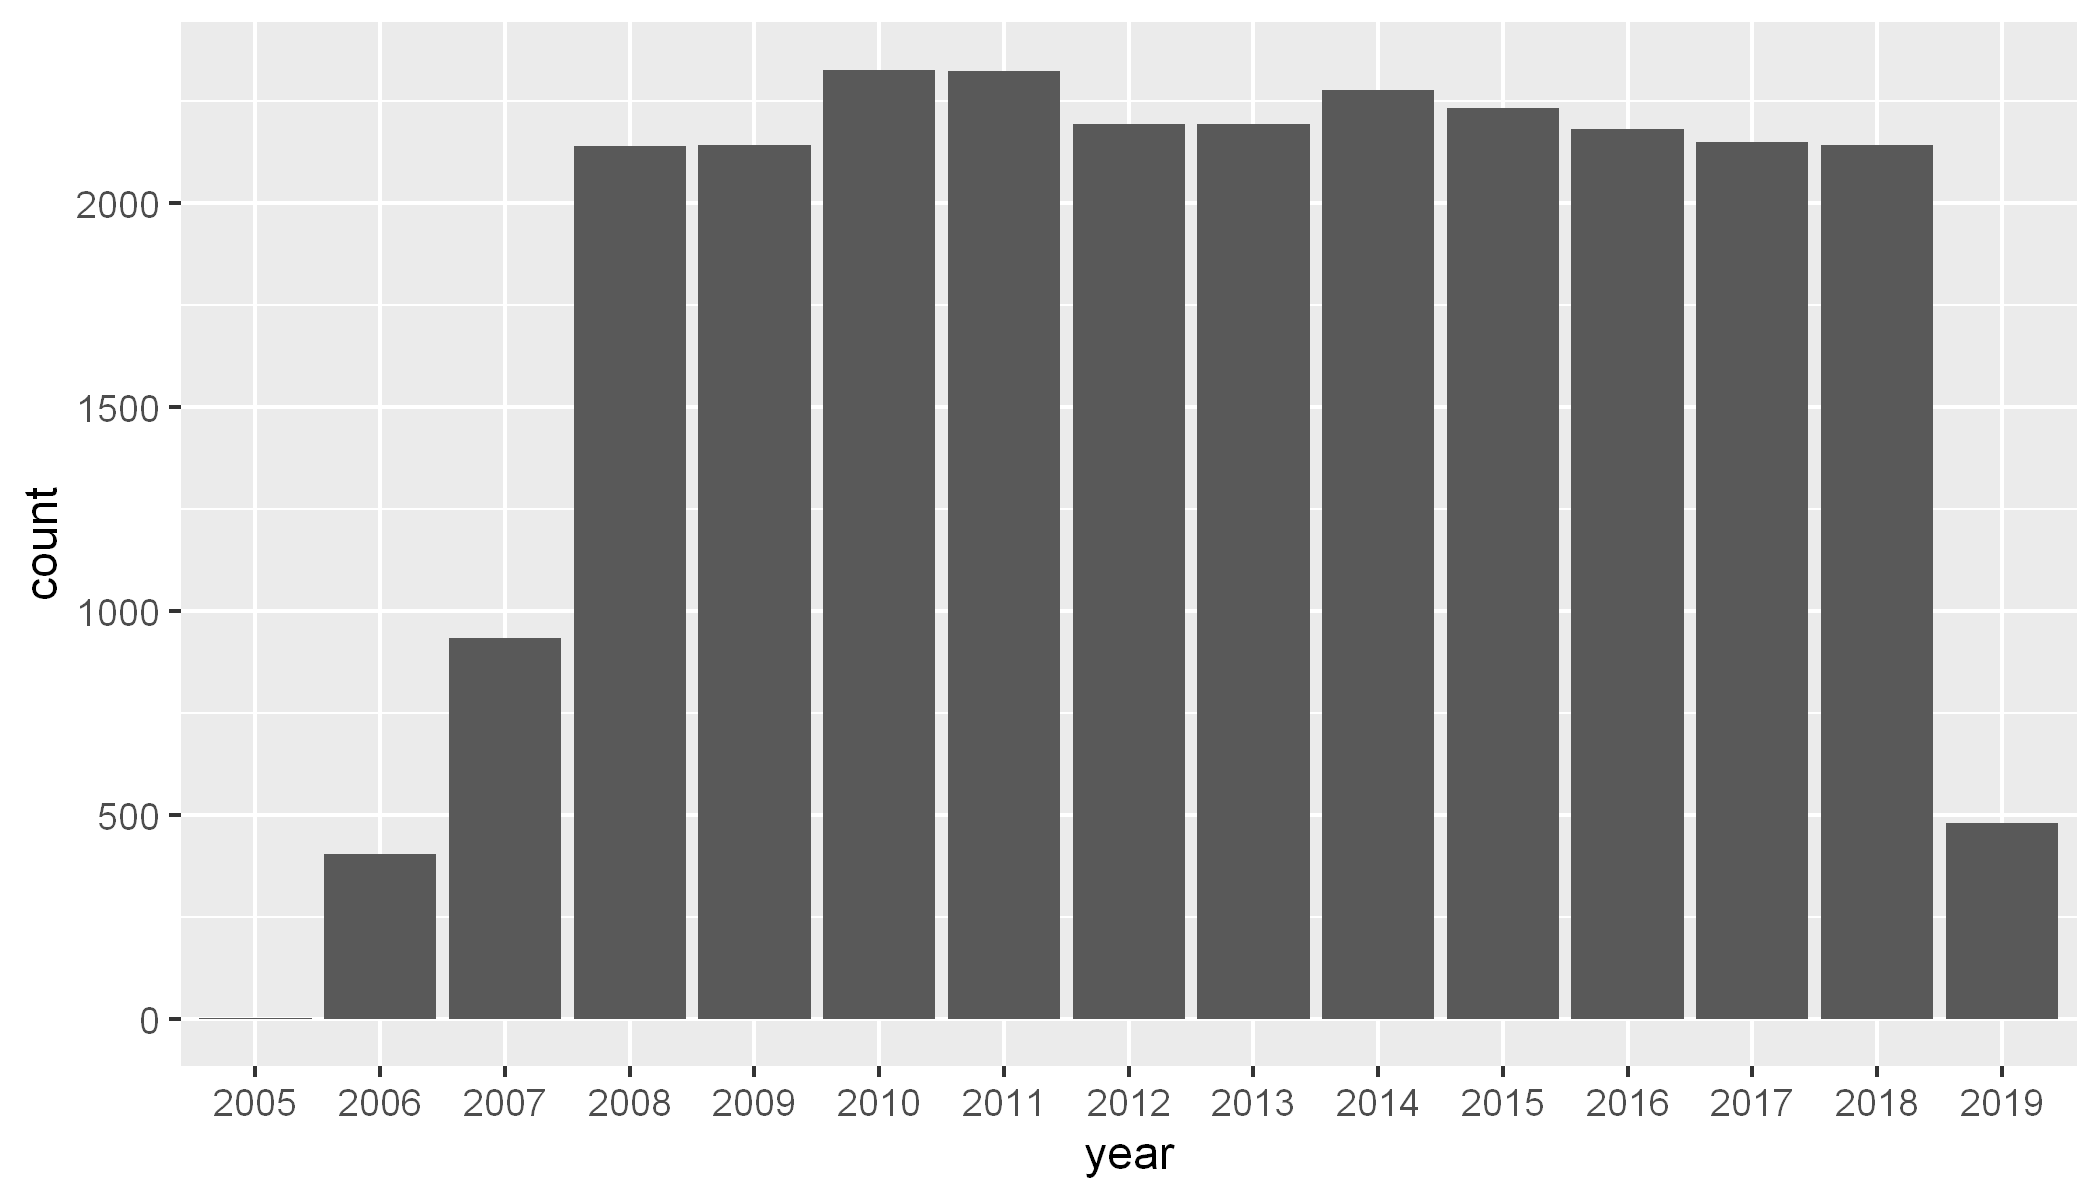

In [11]:
f_sue_keydevid_car_finratio_transcriptid_text[, .(year=as.factor(year(ciq_release_date)))] %>%
    ggplot(aes(x=year)) +
    geom_bar() + 
    scale_x_discrete('year')

## split train/val/test

> I didn't generate new dataset here, instead, I generate the `transcriptid` for train/val/test

In [12]:
ld(f_sue_keydevid_car_finratio_transcriptid_text)

-f_sue_keydevid_car_finratio_transcriptid_text- loaded  (16.03 secs)


> Rolling:
- start: `2008-01-01`
- end: `2018-12-31`
- training period: 5 years (20 quarters)
- predict period: next quarter

In [13]:
train_start = ymd('2008-01-01')
train_end = ymd('2013-01-01')
test_start = ymd('2013-01-01')
test_end = ymd('2013-04-01')

rolling_split_dates = data.table(window='roll-01', train_start=train_start, train_end=train_end, test_start=test_start, test_end=test_end)

i_window = 1
while (test_end < ymd('2018-12-31')) {
    i_window = i_window + 1
    train_start = train_start %m+% months(3)
    train_end = train_end %m+% months(3)
    test_start = test_start %m+% months(3)
    test_end = test_end %m+% months(3)
    
    rolling_split_dates = rbindlist(list(rolling_split_dates, list(window=str_c('roll-', str_pad(i_window, 2, pad = "0")), train_start=train_start, train_end=train_end, test_start=test_start, test_end=test_end)))
}

# add "nonrolling" split
nonrolling_split = list(window='non-roll-01', 
                        train_start=ymd('2008-01-01'),
                        train_end=ymd('2018-12-31'),
                        test_start=ymd('2019-01-01'),
                        test_end=ymd('2019-12-31'))
rolling_split_dates = rbindlist(list(rolling_split_dates, nonrolling_split), fill=T)
rolling_split_dates

# write to csv
fwrite(rolling_split_dates, './data/split_dates.csv')

window,train_start,train_end,test_start,test_end
<chr>,<date>,<date>,<date>,<date>
roll-01,2008-01-01,2013-01-01,2013-01-01,2013-04-01
roll-02,2008-04-01,2013-04-01,2013-04-01,2013-07-01
roll-03,2008-07-01,2013-07-01,2013-07-01,2013-10-01
roll-04,2008-10-01,2013-10-01,2013-10-01,2014-01-01
roll-05,2009-01-01,2014-01-01,2014-01-01,2014-04-01
roll-06,2009-04-01,2014-04-01,2014-04-01,2014-07-01
roll-07,2009-07-01,2014-07-01,2014-07-01,2014-10-01
roll-08,2009-10-01,2014-10-01,2014-10-01,2015-01-01
roll-09,2010-01-01,2015-01-01,2015-01-01,2015-04-01


In [14]:
f_sue_keydevid_car_finratio_transcriptid_text[ciq_call_date %between% c(ymd('2012-07-01'), ymd('2017-07-01')), .N]

[1] 11031

## take a look

In [1]:
ld(f_sue_keydevid_car_finratio_transcriptid_text)

-f_sue_keydevid_car_finratio_transcriptid_text- loaded  (24.48 secs)


In [9]:
f_sue_keydevid_car_finratio_transcriptid_text[1, 1:38]

gvkey,permno,datadate,fyear,fqtr,ciq_release_date,ciq_call_date,rdq,rdq1,repdats,leadrdq1,release_keydevid,call_keydevid,transcriptid,mcap,sue,sue_lag1,sue_lead1,se,se_lag1,se_lead1,sest,sest_lag1,sest_lead1,car_m1_m1,car_m2_m2,car_m30_m3,car_0_1,car_0_30,car_0_30_lag1,bm,roa,debt_asset,alpha,beta_mktrf,beta_smb,beta_hml,volatility
<chr>,<chr>,<date>,<dbl>,<dbl>,<date>,<date>,<date>,<date>,<date>,<date>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
126554,87432,2006-04-30,2006,2,2006-05-15,2006-05-15,2006-05-15,2006-05-15,2006-05-15,2006-08-14,2896139,2859966,108,16366.92,0.0005205622,0.0002948983,0.001758087,0.01041124,0.009436744,0.0161744,0.009890682,0.009141846,0.01441632,-0.02162248,0.01819974,0.02050331,-0.05930359,-0.1365148,-0.105923,0.287,0.071,0.452,0.0004257577,0.9991567,0.4289651,-0.1921524,0.01332718


# Benchmark

In [1]:
ld(f_sue_keydevid_car_finratio_transcriptid_text)

-f_sue_keydevid_car_finratio_transcriptid_text- loaded  (22.97 secs)


In [3]:
f_sue_keydevid_car_finratio_transcriptid_text[, uniqueN(transcriptid)]

[1] 26107

In [192]:
test = copy(f_sue_keydevid_car_finratio_transcriptid_text)[,
      c('text_present', 'text_qa', 'text_ans', 'text_ques') := NULL
    ][ciq_call_date %between% c(ymd('2018-10-01'), ymd('2019-01-01'))]

train = copy(f_sue_keydevid_car_finratio_transcriptid_text)[,
      c('text_present', 'text_qa', 'text_ans', 'text_ques') := NULL
    ][ciq_call_date %between% c(ymd('2013-10-01'), ymd('2018-10-01'))]


lm_car_0_1 = lm(car_0_1 ~ sue + I(log(mcap)) + bm + roa + volatility + car_m1_m1 + car_m2_m2 + car_m30_m3 + alpha,
    data=train)

lm_car_0_30 = lm(car_0_30 ~ sue + I(log(mcap)) + bm + roa + volatility + car_m1_m1 + car_m2_m2 + car_m30_m3 + alpha,
    data=train)

lm_sue = lm(sue_lead1 ~ sue + I(log(mcap)) + bm + roa + volatility + car_m1_m1 + car_m2_m2 + car_m30_m3 + alpha,
    data=train)

In [187]:
mean((test$car_0_30-predict(lm_car_0_30, newdata=test))**2, na.rm=T)

[1] 0.01539943

In [194]:
mean((test$sue-predict(lm_sue, newdata=test))**2, na.rm=T)

[1] 5.086325e-06

In [169]:
(0.01748343-0.0128227445729153)/0.0128227445729153

[1] 0.3634702

In [193]:
# summary(lm_car_0_1)
# summary(lm_car_0_30)
summary(lm_sue)


Call:
lm(formula = sue_lead1 ~ sue + I(log(mcap)) + bm + roa + volatility + 
    car_m1_m1 + car_m2_m2 + car_m30_m3 + alpha, data = train)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.42566 -0.00091 -0.00017  0.00079  0.27023 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)   1.730e-03  9.385e-04   1.843 0.065367 .  
sue           3.775e-01  9.411e-03  40.111  < 2e-16 ***
I(log(mcap)) -4.331e-05  8.196e-05  -0.528 0.597200    
bm           -1.057e-03  2.490e-04  -4.247 2.19e-05 ***
roa          -1.810e-03  1.078e-03  -1.679 0.093248 .  
volatility   -4.661e-03  1.427e-02  -0.327 0.743872    
car_m1_m1    -2.824e-02  6.523e-03  -4.330 1.51e-05 ***
car_m2_m2     1.582e-02  6.920e-03   2.287 0.022245 *  
car_m30_m3    2.616e-03  1.318e-03   1.984 0.047267 *  
alpha        -3.021e-01  8.101e-02  -3.730 0.000193 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.008825 on 9727 degrees of free